# Predictor de precio de propiedades - Properati - Martín Savransky
## Introducción

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
data = pd.read_csv("DS_Proyecto_01_Datos_Properati.csv")

In [ ]:
data.shape

(146660, 19)

Agregamos columnas generadas por la aparición de ciertas palabras que describen las propiedades.
Usamos palabras clave:

`lista_palabras = ['jardin','cochera','parrilla','pileta','terraza','subte','lavadero','dependencia']`

In [ ]:
#creamos nueva columna con palabras de descripción en una lista
data['desc_lista']=[x.lower().split(' ') for x in data['description']]

In [ ]:
#creamos nuevos atributos suponiendo que si la palabra aparece en la descripcion entonces la propiedad cuenta con esa caracteristica
lista_palabras = ['jardin','cochera','parrilla','pileta','terraza','subte','lavadero','dependencia']
for palabra in lista_palabras:
  data[[palabra]] = data.apply(
    lambda row: sum(i == palabra for i in row['desc_lista'])>=1,
    axis=1)

In [ ]:
#convertimos bool a int
for palabra in lista_palabras:
  data[[palabra]] = data[[palabra]].astype(int)

In [ ]:
#chequeamos cantidades de propiedades para cada palabra
for palabra in ['cochera', 'pileta', 'terraza', 'subte', 'lavadero', 'dependencia','jardin', 'parrilla']:
    print(palabra, data[palabra].sum())

cochera 28086
pileta 13133
terraza 23931
subte 18471
lavadero 32396
dependencia 11300
jardin 3120
parrilla 18166


In [ ]:
#Descartamos la columna auxiliar creada
data = data.drop(['desc_lista'],axis = 1)

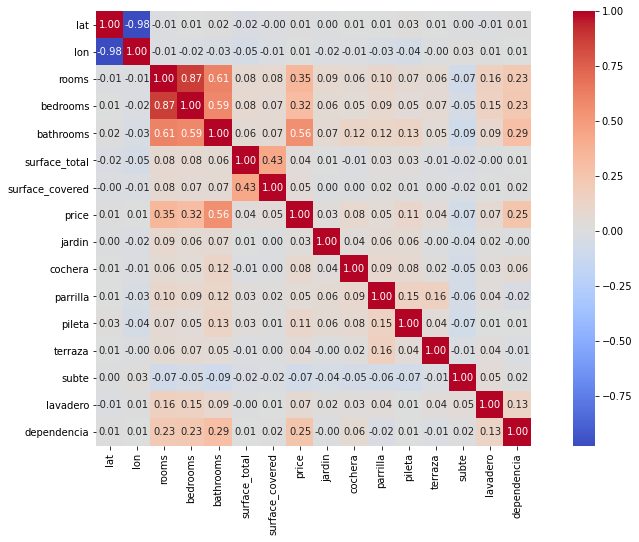

In [ ]:
plt.rcParams['figure.figsize'] = (15,8)
corr = data.corr()
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 10},
           cmap= 'coolwarm')
plt.show()

In [ ]:
data.head()

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type,jardin,cochera,parrilla,pileta,terraza,subte,lavadero,dependencia
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta,0,0,0,0,0,0,0,0
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta,0,0,0,0,0,0,0,0
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta,0,0,0,0,0,0,0,0
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta,0,0,0,0,0,0,0,0
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,PH,Venta,0,0,0,0,1,0,0,0


Quitamos 8 columnas y nos quedamos con propiedades de tipo depto, casa o ph.
1. Las tres columnas correspondientes a las fechas.
2. Todas las propiedades son de Argentina.
3. Todas las propiedades se publican en dolares.
4. Todas las propiedades se publican para venta.
5. Las columnas *titulo* y *descripción* también las descartamos.

In [ ]:
data = data.drop(['start_date','end_date','created_on', 'l1', 'currency', 'operation_type','title','description'], axis =1)
data = data[data.property_type.isin(['Departamento', 'Casa', 'PH'])] 

Comienzo

In [ ]:
data.describe(include='all').round(2)

,lat,lon,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,jardin,cochera,parrilla,pileta,terraza,subte,lavadero,dependencia
count,133552.00,133521.00,143145,143145,143145.00,143145.00,138934.00,124522.00,124236.00,143145.00,143145,143145.00,143145.00,143145.00,143145.00,143145.00,143145.00,143145.00,143145.00
unique,NaN,NaN,4,89,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Capital Federal,Palermo,NaN,NaN,NaN,NaN,NaN,NaN,Departamento,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,91485,13007,NaN,NaN,NaN,NaN,NaN,NaN,107326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,-34.60,-58.46,NaN,NaN,3.10,2.00,1.60,182.38,112.37,237818.38,NaN,0.02,0.19,0.13,0.09,0.17,0.13,0.23,0.08
std,0.47,0.49,NaN,NaN,1.39,1.13,0.89,1436.71,919.03,288100.41,NaN,0.15,0.39,0.33,0.29,0.37,0.33,0.42,0.27
min,-35.15,-180.00,NaN,NaN,1.00,0.00,1.00,10.00,1.00,6000.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,-34.63,-58.50,NaN,NaN,2.00,1.00,1.00,52.00,47.00,112000.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,-34.60,-58.44,NaN,NaN,3.00,2.00,1.00,78.00,68.00,166000.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,-34.57,-58.41,NaN,NaN,4.00,3.00,2.00,138.00,108.00,264465.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Outliers en:


*   lat: max de 85
*   lon: min de -180
*   rooms: max de 35
*   bedrooms: min de 0 y max de 15
*   bathrooms: max de 14
*   surface_total: max de 169000
*   surface_covered: max de 126062
*   price: max de 3x10^7



In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143145 entries, 0 to 146659
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   lat              133552 non-null  float64
 1   lon              133521 non-null  float64
 2   l2               143145 non-null  object 
 3   l3               143145 non-null  object 
 4   rooms            143145 non-null  float64
 5   bedrooms         143145 non-null  float64
 6   bathrooms        138934 non-null  float64
 7   surface_total    124522 non-null  float64
 8   surface_covered  124236 non-null  float64
 9   price            143145 non-null  float64
 10  property_type    143145 non-null  object 
 11  jardin           143145 non-null  int64  
 12  cochera          143145 non-null  int64  
 13  parrilla         143145 non-null  int64  
 14  pileta           143145 non-null  int64  
 15  terraza          143145 non-null  int64  
 16  subte            143145 non-null  int6

# PARTE A - Transformación de Datos

Implementa las transformaciones que elegiste. Justificamos en cada punto.

1.Detección y eliminación de Outliers

2.Encoding

3.Imputación de valores faltantes

4.Escalado de datos

5.Generación de nuevas variables predictoras/reducción de dimensionalidad (SVD/PCA).

## Detección y eliminación de Outliers

1. Hacemos un `boxplot` de los atributos numéricos.
2. Los estadísticos principales de la muestra: valor medio, desviación estándar, cuartiles, máximo, mínimo, etc. los mostamos previamente.
3. Aplicamos la técnica del rango interquartílico y la regla de las tres sigmas para seleccionar outliers.
4. Seleccionamos outliers y los descartamos.
5. Hacemos algunos descartes adicionales `a ojo`.

Columnas numéricas de tipo float:
*lat, lon, rooms, bedrooms, bathrooms, surface_total, surface_covered, price.*

In [ ]:
nuemerical_cols = data.select_dtypes(include=['float64'])

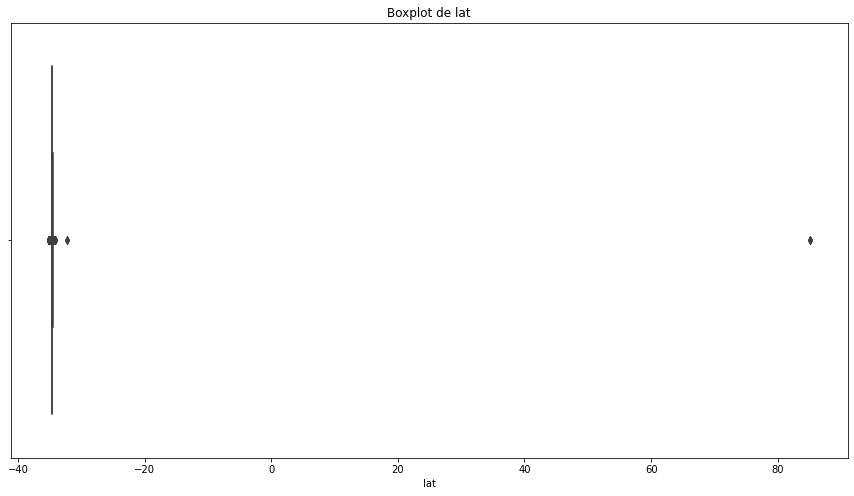

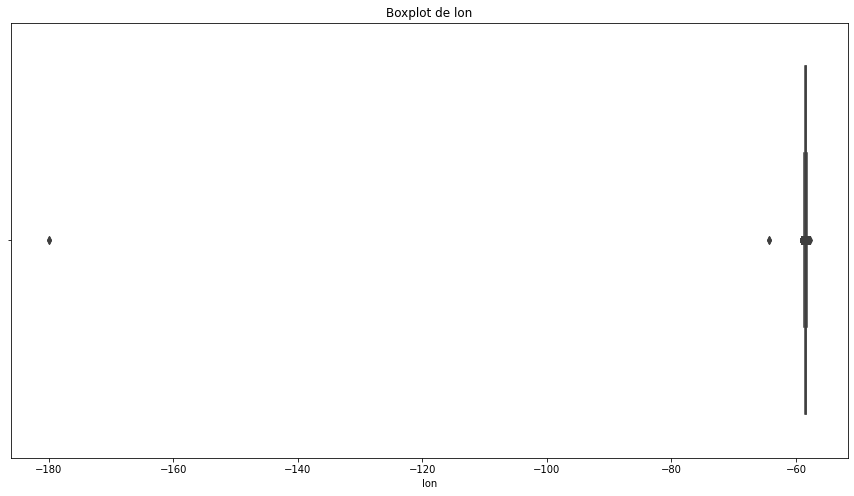

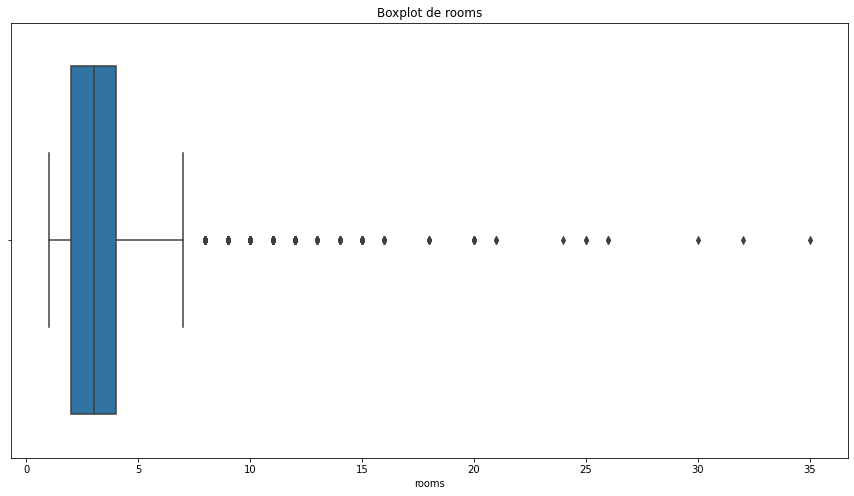

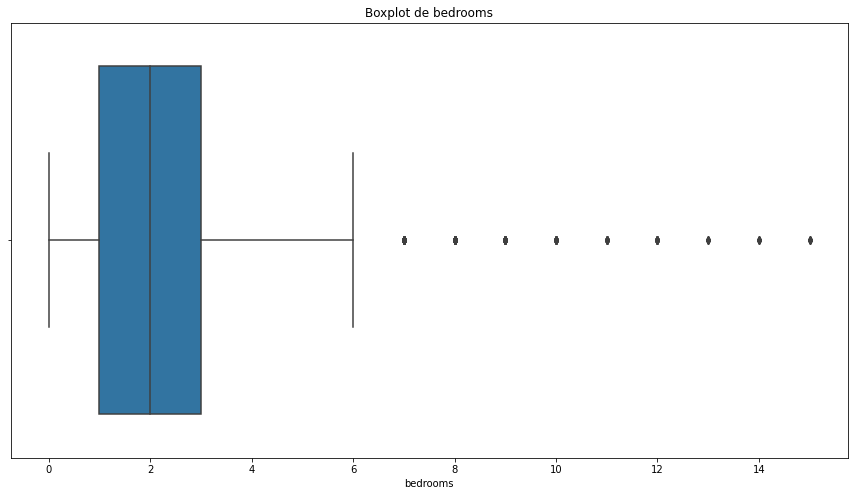

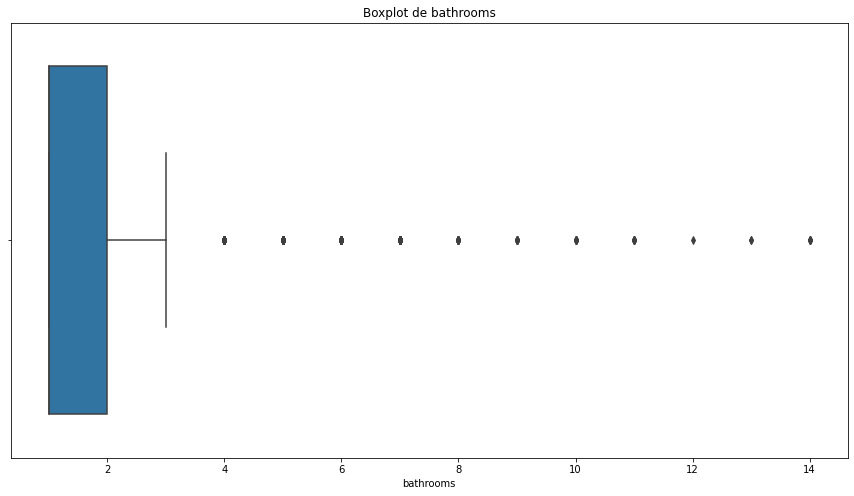

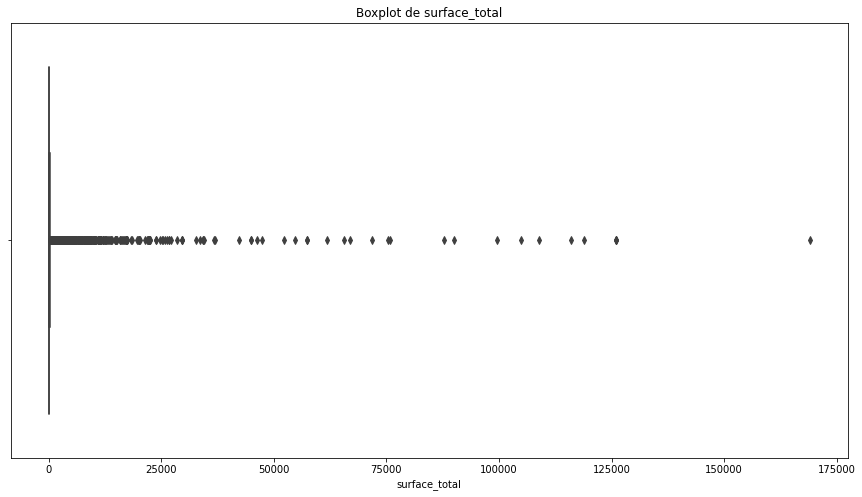

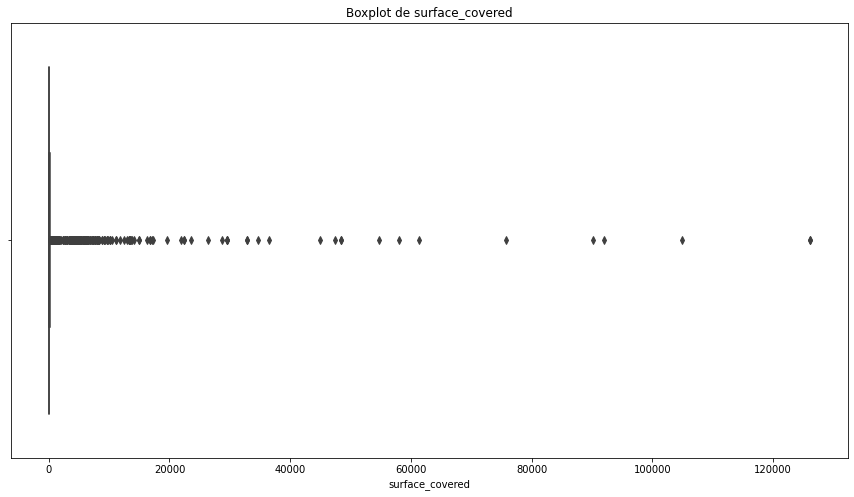

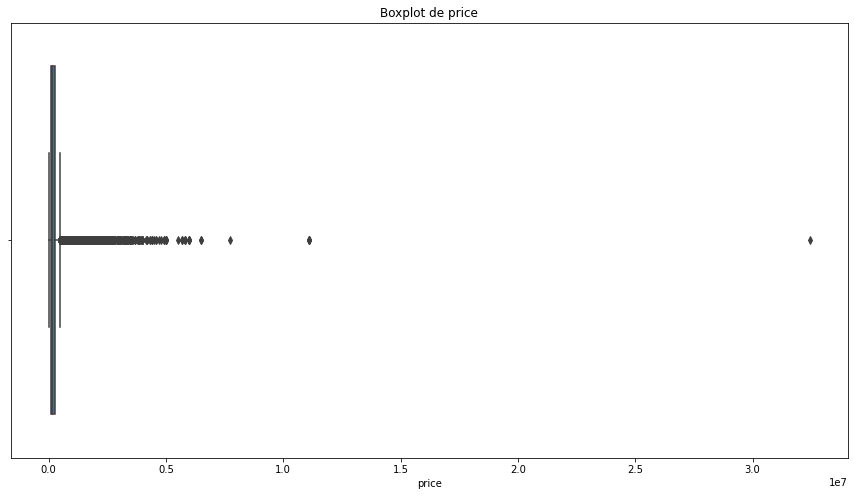

In [ ]:
for columna in nuemerical_cols:
  ax = sns.boxplot(x=data[columna])
  plt.title('Boxplot de ' + str(columna))
  plt.show()

-El criterio de las **tres sigmas**. Elige los umbrales mínimo y máximo de la siguiente manera:

mínimo = valor medio - 3 x SD

máximo = valor medio + 3 x SD

Es decir, el umbral mínimo es el valor tres sigmas por debajo del valor medio y el umbral máximo el valor tres sigmas por encima del valor medio.

-El criterio del **rango intercuartílico** elige los umbrales mínimo y máximo de esta otra:

mínimo = Q1 - 1.5 x IQR

máximo = Q3 + 1.5 x IQR

Q1 es el primer cuartil, Q3 es el tercer cuartil e IQR es Q3 - Q1, el rango intercuartílico.


*Cuando la distribución esta sesgada usamos IQR, si es normal usamos 3 sigmas.*




In [ ]:
# Método 3 sigmas - estudiamos intervalos
dictio_3s = {}
for columna in nuemerical_cols:
  #tres sigmas
  #print(str(columna))
  columna_mean = data[columna].mean()
  columna_sdt = data[columna].std() 
  
  min_3s = columna_mean  - 3*columna_sdt
  max_3s = columna_mean  + 3*columna_sdt
  dictio_3s[columna] = [min_3s,max_3s]
  #print('(' + str(min_3s) + ',' + str(max_3s) + ')')
  mascara_outliers = np.logical_or(data[columna] < min_3s, data[columna] > max_3s)
    
  print(str(columna) + ':','Perdemos',mascara_outliers.sum(), 'instancias')
print(dictio_3s)  
  

lat: Perdemos 4 instancias
lon: Perdemos 4 instancias
rooms: Perdemos 1384 instancias
bedrooms: Perdemos 1100 instancias
bathrooms: Perdemos 1608 instancias
surface_total: Perdemos 311 instancias
surface_covered: Perdemos 197 instancias
price: Perdemos 2361 instancias
{'lat': [-36.02303903606033, -33.18347554613285], 'lon': [-59.93800867082388, -56.991380994885255], 'rooms': [-1.0831251549431369, 7.275405709625453], 'bedrooms': [-1.387878910658452, 5.386858965847246], 'bathrooms': [-1.06022440819508, 4.255655332230953], 'surface_total': [-4127.744124924045, 4492.506303494899], 'surface_covered': [-2644.7026905983216, 2869.4510083162136], 'price': [-626482.8345745679, 1102119.5968924973]}


In [ ]:
# Método IQR - estudiamos intervalos
dictio_IQR = {}
for columna in nuemerical_cols:
  Q1 = data[columna].quantile(0.25)
  Q3 = data[columna].quantile(0.75)
  IQR = Q3-Q1
  min_IQR = Q1 - 3/2*IQR
  max_IQR = Q3 + 3/2*IQR
  dictio_IQR[columna] = [min_IQR, max_IQR]
  mascara_outliers = np.logical_or(data[columna] < min_IQR, data[columna] > max_IQR)
  print(str(columna) + ':','Perdemos',mascara_outliers.sum(), 'instancias')
print(dictio_IQR)  

lat: Perdemos 26639 instancias
lon: Perdemos 17110 instancias
rooms: Perdemos 1384 instancias
bedrooms: Perdemos 395 instancias
bathrooms: Perdemos 5486 instancias
surface_total: Perdemos 12770 instancias
surface_covered: Perdemos 9944 instancias
price: Perdemos 10640 instancias
{'lat': [-34.70459373749999, -34.496122437500006], 'lon': [-58.64571600000001, -58.265816799999996], 'rooms': [-1.0, 7.0], 'bedrooms': [-2.0, 6.0], 'bathrooms': [-0.5, 3.5], 'surface_total': [-77.0, 267.0], 'surface_covered': [-44.5, 199.5], 'price': [-116697.5, 493162.5]}


In [ ]:
# Creamos masacaras y filtramos en cada atributo elegimos el método más conveniente 
mascara_outliers = np.logical_and(
np.logical_not(np.logical_or(data['lat'] < dictio_3s['lat'][0]  , data['lat'] > dictio_3s['lat'][1])),
np.logical_not(np.logical_or(data['lon'] < dictio_3s['lon'][0]  , data['lon'] > dictio_3s['lon'][1])))
print(mascara_outliers.sum())
data = data[mascara_outliers]
print(data.shape)

mascara_outliers1 = np.logical_and(
np.logical_not(np.logical_or(data['rooms'] < dictio_3s['rooms'][0]  , data['rooms'] > dictio_3s['rooms'][1])),
np.logical_not(np.logical_or(data['bedrooms'] < dictio_3s['bedrooms'][0]  , data['bedrooms'] > dictio_3s['bedrooms'][1])))
print(mascara_outliers1.sum())
data = data[mascara_outliers1]
print(data.shape)

mascara_outliers2 = np.logical_and(
np.logical_not(np.logical_or(data['bathrooms'] < dictio_IQR['bathrooms'][0]  , data['bathrooms'] > dictio_IQR['bathrooms'][1])),
np.logical_not(np.logical_or(data['price'] < dictio_3s['price'][0]  , data['price'] > dictio_3s['price'][1])))
print(mascara_outliers2.sum())
data = data[mascara_outliers2]
print(data.shape)

mascara_outliers3 = np.logical_and(
np.logical_not(np.logical_or(data['surface_total'] < dictio_IQR['surface_total'][0]  , data['surface_total'] > dictio_IQR['surface_total'][1])),
np.logical_not(np.logical_or(data['surface_covered'] < dictio_IQR['surface_covered'][0]  , data['surface_covered'] > dictio_IQR['surface_covered'][1])))
print(mascara_outliers3.sum())
data = data[mascara_outliers3]
print(data.shape)


143141
(143141, 19)
141235
(141235, 19)
135600
(135600, 19)
124499
(124499, 19)


Descartamos 18.646 instacias con valores atipicos.

(143145 - 124499 = 18646)

In [ ]:
data.describe().round(2)

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,jardin,cochera,parrilla,pileta,terraza,subte,lavadero,dependencia
count,116410.00,116381.00,124499.00,124499.00,120674.00,106927.00,106650.00,124499.00,124499.00,124499.00,124499.00,124499.00,124499.00,124499.00,124499.00,124499.00
mean,-34.60,-58.46,2.81,1.79,1.42,83.27,70.14,191374.26,0.02,0.19,0.11,0.07,0.16,0.14,0.22,0.06
std,0.09,0.13,1.06,0.93,0.62,46.63,34.37,127850.06,0.13,0.39,0.31,0.26,0.37,0.35,0.41,0.24
min,-35.12,-59.04,1.00,0.00,1.00,10.00,1.00,6000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,-34.62,-58.49,2.00,1.00,1.00,50.00,45.00,109000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,-34.60,-58.44,3.00,2.00,1.00,70.00,60.00,155000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,-34.58,-58.41,3.00,2.00,2.00,103.00,86.00,235000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,-34.21,-57.84,7.00,5.00,3.00,267.00,199.00,1100007.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [ ]:
#Filtramos a ojo las siguientes:
data = data[(data.price>=10000) & (data.bedrooms>=1)]

In [ ]:
#Filtramos a ojo las siguientes:
data = data[(data.surface_total>=data.surface_covered) & (data.surface_total>=15)]

In [ ]:
data.shape

(104638, 19)

## Encoding
Tenemos 3 columnas de tipo *object*.
Hacemos dummies para property_type y para l2 (región).
Luego, hacemos clustering y dummies para l3 (barrio).

In [ ]:
data = pd.get_dummies(data, columns=['property_type','l2'])

In [ ]:
data.head()

,lat,lon,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,jardin,cochera,parrilla,pileta,terraza,subte,lavadero,dependencia,property_type_Casa,property_type_Departamento,property_type_PH,l2_Bs.As. G.B.A. Zona Norte,l2_Bs.As. G.B.A. Zona Oeste,l2_Bs.As. G.B.A. Zona Sur,l2_Capital Federal
1,-34.624056,-58.412110,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,-34.593569,-58.427474,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,-34.581294,-58.436754,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,-34.914194,-57.938219,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
5,-34.593779,-58.441239,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1


Hacemos clustering para l3.

In [ ]:
#Calculo el valor del m2 para unificar
data['valor_m2_miles'] = (data.price/((data.surface_covered+data.surface_total)/2))/1000
#Creo la nueva variable en que colocaré la media de precio por metro cuadrado que le corresponde al barrio en que se ubica la propiedad
data['valorMedio_M2_Barrio'] = data.groupby(['l3'])['valor_m2_miles'].transform('mean')

In [ ]:
data.valorMedio_M2_Barrio.unique()
#obtuvimos las medias (una por cada barrio)

array([2.21152123, 3.4978085 , 1.48162438, 2.55020391, 2.01214769,
       2.54966177, 1.82239213, 2.75172362, 2.51336455, 2.19717336,
       1.5794724 , 3.40061126, 2.54766989, 3.45967223, 1.91937606,
       3.4033192 , 2.17578661, 2.69079829, 2.56851998, 2.46558966,
       2.90931909, 1.65097457, 2.78085697, 1.48949382, 2.25962962,
       3.22957298, 3.86876624, 2.353545  , 2.9682713 , 3.01855604,
       2.53908452, 1.44795603, 2.18630202, 1.4062665 , 1.85988617,
       2.08204278, 3.00868522, 2.12891857, 1.53792185, 2.29270746,
       5.83826568, 2.05909531, 2.70048912, 2.0506972 , 2.34683614,
       2.16881372, 2.95658623, 2.18979806, 2.26133857, 2.68547696,
       2.24283089, 2.41427478, 1.29864363, 1.71885201, 1.91941236,
       2.50487738, 1.71963459, 1.24588972, 1.55146655, 1.56172044,
       1.20545499, 1.76671635, 1.73350327, 1.11475291, 0.86222767,
       1.57250165, 1.32400752, 1.16419789, 1.57431925, 1.4053876 ,
       1.01889486, 2.4485821 , 1.24433288, 1.24413768, 2.41736

In [ ]:
data.columns
#Voy a crear la matriz con que alimento al modelo de agrupamiento


Index(['lat', 'lon', 'l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'jardin', 'cochera', 'parrilla', 'pileta',
       'terraza', 'subte', 'lavadero', 'dependencia', 'property_type_Casa',
       'property_type_Departamento', 'property_type_PH',
       'l2_Bs.As. G.B.A. Zona Norte', 'l2_Bs.As. G.B.A. Zona Oeste',
       'l2_Bs.As. G.B.A. Zona Sur', 'l2_Capital Federal', 'valor_m2_miles',
       'valorMedio_M2_Barrio'],
      dtype='object')

In [ ]:
X_valorMedio = data.drop(['lat', 'lon', 'l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'property_type_Casa',
       'property_type_Departamento', 'property_type_PH',
       'l2_Bs.As. G.B.A. Zona Norte', 'l2_Bs.As. G.B.A. Zona Oeste',
       'l2_Bs.As. G.B.A. Zona Sur', 'l2_Capital Federal', 'valor_m2_miles','price', 'parrilla', 'jardin', 'cochera',
       'pileta', 'terraza', 'subte', 'lavadero', 'dependencia'], axis=1)

In [ ]:
X_valorMedio_2d = X_valorMedio.values.reshape(-1,1)

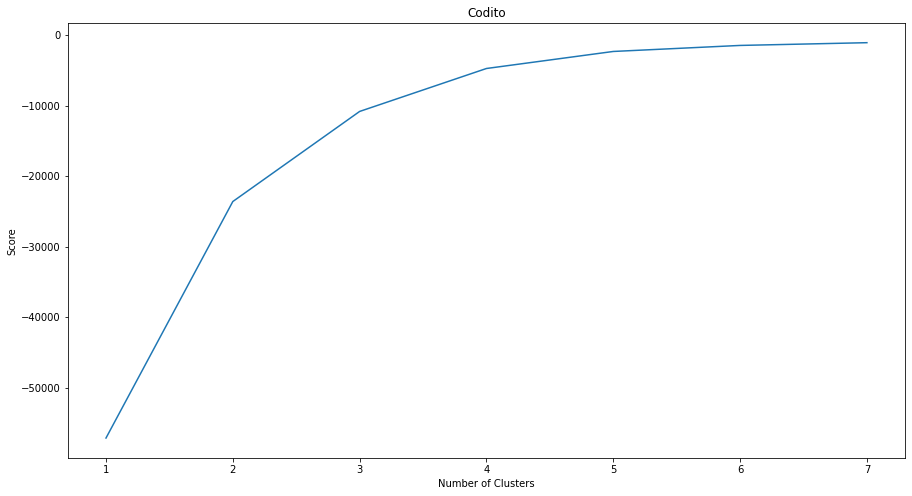

In [ ]:
from sklearn.cluster import KMeans
# Graficamos el score para distintos cantidad de cluster's. Seleccionamos el codo de la curva de scores.
Nc = range(1, 8)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X_valorMedio_2d).score(X_valorMedio_2d) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Codito')
plt.show()

In [ ]:
from sklearn.cluster import KMeans

# Especificamos el numero adecuado de clusters
# Elegimos n_clusters = 4
kmeans_1 = KMeans(n_clusters=4, random_state=42, n_jobs=-1)

In [ ]:
kmeans_1.fit(X_valorMedio_2d)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [ ]:
y_kmeans = kmeans_1.predict(X_valorMedio_2d)

centros_1 = kmeans_1.cluster_centers_
print(centros_1)

[[3.35381062]
 [1.58357539]
 [5.83826568]
 [2.5058039 ]]


In [ ]:
#Consultamos las etiquetas
etiquetas_1 = kmeans_1.labels_

#Number of clusters in labels, ignoring noise if present.
n_clusters_1 = len(set(etiquetas_1)) - (1 if -1 in etiquetas_1 else 0)
n_noise_1 = list(etiquetas_1).count(-1)

In [ ]:
print('Estimated number of clusters: %d' % n_clusters_1)
print('Estimated number of noise points: %d' % n_noise_1)

Estimated number of clusters: 4
Estimated number of noise points: 0


In [ ]:
#Inserto nueva columna en data con los valores de clusters del K-Means
data['Kmeans_Barrio']=kmeans_1.labels_
data.head()

,lat,lon,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,jardin,cochera,parrilla,pileta,terraza,subte,lavadero,dependencia,property_type_Casa,property_type_Departamento,property_type_PH,l2_Bs.As. G.B.A. Zona Norte,l2_Bs.As. G.B.A. Zona Oeste,l2_Bs.As. G.B.A. Zona Sur,l2_Capital Federal,valor_m2_miles,valorMedio_M2_Barrio,Kmeans_Barrio
1,-34.624056,-58.412110,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2.484375,2.211521,3
2,-34.593569,-58.427474,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2.777778,3.497808,0
3,-34.581294,-58.436754,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,4.370370,3.497808,0
4,-34.914194,-57.938219,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0.941176,1.481624,1
5,-34.593779,-58.441239,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,2.678571,2.550204,3


In [ ]:
# Hacemos dummies al cluster por barrios
data = pd.get_dummies(data, columns = ['Kmeans_Barrio'])

In [ ]:
# Tiramos las variables auxiliares creadas
data.drop(columns=['valor_m2_miles', 'valorMedio_M2_Barrio'], inplace=True)
data.head()

,lat,lon,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,jardin,cochera,parrilla,pileta,terraza,subte,lavadero,dependencia,property_type_Casa,property_type_Departamento,property_type_PH,l2_Bs.As. G.B.A. Zona Norte,l2_Bs.As. G.B.A. Zona Oeste,l2_Bs.As. G.B.A. Zona Sur,l2_Capital Federal,Kmeans_Barrio_0,Kmeans_Barrio_1,Kmeans_Barrio_2,Kmeans_Barrio_3
1,-34.624056,-58.412110,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
2,-34.593569,-58.427474,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0
3,-34.581294,-58.436754,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0
4,-34.914194,-57.938219,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0
5,-34.593779,-58.441239,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1


## Imputación de valores faltantes


In [ ]:
data.isna().sum()

lat                            6959
lon                            6959
l3                                0
rooms                             0
bedrooms                          0
bathrooms                      1296
surface_total                     0
surface_covered                   0
price                             0
jardin                            0
cochera                           0
parrilla                          0
pileta                            0
terraza                           0
subte                             0
lavadero                          0
dependencia                       0
property_type_Casa                0
property_type_Departamento        0
property_type_PH                  0
l2_Bs.As. G.B.A. Zona Norte       0
l2_Bs.As. G.B.A. Zona Oeste       0
l2_Bs.As. G.B.A. Zona Sur         0
l2_Capital Federal                0
Kmeans_Barrio_0                   0
Kmeans_Barrio_1                   0
Kmeans_Barrio_2                   0
Kmeans_Barrio_3             

In [ ]:
data.shape

(104638, 28)

Baños

In [ ]:
#Cantidad de baños de las propiedades
data['bathrooms'].unique()

array([ 2.,  1.,  3., nan])

In [ ]:
#Cantidad de faltantes en baños agrupado por cantidad de rooms
data.bathrooms.isnull().groupby([data['rooms']]).sum().astype(int).reset_index(name='count')

,rooms,count
0,1.0,93
1,2.0,454
2,3.0,461
3,4.0,198
4,5.0,82
5,6.0,8
6,7.0,0


Completamos los faltantes en baños en función de la cantidad de rooms (rooms no tiene faltantes):

---
Si rooms = 0, entonces bathrooms = 1

Si rooms = 1, entonces bathrooms = 1

Si rooms = 2, entonces bathrooms = 2

Si rooms = 3, entonces bathrooms = 2

Si rooms = 4, entonces bathrooms = 3

Si rooms = 5, entonces bathrooms = 3

Si rooms = 6, entonces bathrooms = 4


In [ ]:
data['bathrooms'] = data.apply(
    lambda row: (row['rooms']//2 +1) if np.isnan(row['bathrooms']) else row['bathrooms'],
    axis=1
)

In [ ]:
data['bathrooms'].isnull().sum()

0

Superficie total y Superficie Cubierta

Al haber realizado el siguiente drop:

`data = data[(data.surface_total>=data.surface_covered) & (data.surface_total>=15)]`

no quedan valores faltantes en estas columnas. Sin embargo, dejamos la muestra del trabajo realizado previamente a tomar esta decisión. Estas líneas de código no cambian el dataset.

In [ ]:
data.surface_total.isnull().groupby([data['bedrooms']]).sum().astype(int).reset_index(name='count')

,bedrooms,count
0,1.0,0
1,2.0,0
2,3.0,0
3,4.0,0
4,5.0,0


In [ ]:
data.surface_total.isnull().groupby([data['rooms']]).sum().astype(int).reset_index(name='count')

,rooms,count
0,1.0,0
1,2.0,0
2,3.0,0
3,4.0,0
4,5.0,0
5,6.0,0
6,7.0,0


In [ ]:
np.sort(data.groupby(['rooms'])['surface_total'].transform('mean').unique())

array([ 40.38302473,  53.07962363,  87.67230778, 125.37102456,
       158.18160706, 176.86910995, 186.72988506])

In [ ]:
data['sup_promedio'] = data.groupby(['rooms'])['surface_total'].transform('mean')

In [ ]:
data['surface_total'] = data.apply(
    lambda row: row['sup_promedio'] if np.isnan(row['surface_total']) else row['surface_total'],
    axis=1
)

In [ ]:
data.surface_total.isnull().sum()

0

In [ ]:
data['sup_cov_promedio'] = data.groupby(['rooms'])['surface_covered'].transform('mean')
print(np.sort(data.sup_cov_promedio.unique()))
data['surface_covered'] = data.apply(
    lambda row: row['sup_cov_promedio'] if np.isnan(row['surface_covered']) else row['surface_covered'],
    axis=1
)

[ 35.71050142  46.02999033  72.31612886 105.06476449 130.63260567
 143.6954023  146.07225131]


In [ ]:
data.surface_covered.isnull().sum()

0

In [ ]:
data = data.drop(['sup_promedio','sup_cov_promedio'],axis = 1)

In [ ]:
data.columns

Index(['lat', 'lon', 'l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'jardin', 'cochera', 'parrilla', 'pileta',
       'terraza', 'subte', 'lavadero', 'dependencia', 'property_type_Casa',
       'property_type_Departamento', 'property_type_PH',
       'l2_Bs.As. G.B.A. Zona Norte', 'l2_Bs.As. G.B.A. Zona Oeste',
       'l2_Bs.As. G.B.A. Zona Sur', 'l2_Capital Federal', 'Kmeans_Barrio_0',
       'Kmeans_Barrio_1', 'Kmeans_Barrio_2', 'Kmeans_Barrio_3'],
      dtype='object')

Latitud y Longitud

In [ ]:
data.lat.isnull().groupby([data['l3']]).sum().astype(int)


l3
Abasto                4
Agronomía             0
Almagro             159
Almirante Brown       2
Avellaneda           36
                   ... 
Villa Riachuelo       0
Villa Santa Rita      0
Villa Soldati         0
Villa Urquiza        43
Villa del Parque      1
Name: lat, Length: 89, dtype: int64

In [ ]:
#Completamos faltantes en lat y lon usando el promedio de los valores agrupando por barrio respectivamente.
data['lat'].fillna(data.groupby(['l3'])['lat'].transform('mean'), inplace=True)
data['lon'].fillna(data.groupby(['l3'])['lon'].transform('mean'), inplace=True)

Chequeamos que no queden valores faltantes:

In [ ]:
data.isnull().sum()

lat                            0
lon                            0
l3                             0
rooms                          0
bedrooms                       0
bathrooms                      0
surface_total                  0
surface_covered                0
price                          0
jardin                         0
cochera                        0
parrilla                       0
pileta                         0
terraza                        0
subte                          0
lavadero                       0
dependencia                    0
property_type_Casa             0
property_type_Departamento     0
property_type_PH               0
l2_Bs.As. G.B.A. Zona Norte    0
l2_Bs.As. G.B.A. Zona Oeste    0
l2_Bs.As. G.B.A. Zona Sur      0
l2_Capital Federal             0
Kmeans_Barrio_0                0
Kmeans_Barrio_1                0
Kmeans_Barrio_2                0
Kmeans_Barrio_3                0
dtype: int64

## Escalado de datos

Salvo por árboles de decisión, los modelos de ML dependen básicamente de variables numéricas. Y estas deben estar en escalas comparables, ya que los modelos no entienden de unidades. Aplicamos MinMaxScaler a las columnas ['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']. De esta forma obtenemos todas nuestras columnas con valores entre 0 y 1.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
#Definimos las columnas a escalar
cols_scal = ['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']

In [ ]:
#Aplicamos el scaler a cada columna
for col in cols_scal:
  data[[col]] = scaler.fit_transform(data[[col]])

data.head()

,lat,lon,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,jardin,cochera,parrilla,pileta,terraza,subte,lavadero,dependencia,property_type_Casa,property_type_Departamento,property_type_PH,l2_Bs.As. G.B.A. Zona Norte,l2_Bs.As. G.B.A. Zona Oeste,l2_Bs.As. G.B.A. Zona Sur,l2_Capital Federal,Kmeans_Barrio_0,Kmeans_Barrio_1,Kmeans_Barrio_2,Kmeans_Barrio_3
1,0.569476,0.514406,Boedo,0.166667,0.0,0.333333,0.218254,0.287879,159000.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
2,0.604428,0.501418,Palermo,0.166667,0.0,0.000000,0.119048,0.222222,125000.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0
3,0.618501,0.493573,Palermo,0.166667,0.0,0.000000,0.277778,0.247475,295000.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0
4,0.236842,0.915022,La Plata,0.166667,0.0,0.000000,0.138889,0.171717,40000.0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0
5,0.604187,0.489782,Villa Crespo,0.166667,0.0,0.000000,0.162698,0.277778,150000.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1


## Generación de nuevas variables predictoras/reducción de dimensionalidad (SVD/PCA).


Usamos PCA para obtener una reducción dimensional del dataset. Como ventaja, los modelos corren más ráridamente. Como deventaja su desempeño puede llegar a ser peor. 

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(0.95)

In [ ]:
data_pca = data.drop(['l3','price'], axis=1)
data_pca = pd.DataFrame(pca.fit_transform(data_pca))
data.reset_index(inplace=True)
data_pca['price'] = np.log(data['price'])
data_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,price
0,-0.153110,-0.625311,0.915733,-0.095498,-0.586211,0.041195,-0.362433,0.128967,-0.573457,0.032306,-0.057318,0.044794,-0.162916,0.053878,11.976659
1,-0.074406,0.726308,0.806408,-0.076666,-0.802755,0.274202,-0.272843,0.377921,-0.655471,0.059971,-0.084166,0.021885,-0.090147,0.130314,11.736069
2,-0.060672,0.729019,0.829806,-0.038918,-0.794908,0.265523,-0.302699,0.354640,-0.616594,0.059321,-0.079090,0.024977,-0.077693,0.114446,12.594731
3,1.453376,0.047884,0.928404,-0.528303,-0.518379,-0.168884,0.683248,0.135809,-0.202722,-0.356318,-0.821314,-0.008585,-0.272421,0.155818,10.596635
4,-0.109000,-0.662643,1.089072,0.101572,-0.843791,-0.003883,0.474413,0.046256,-0.418478,-0.326190,-0.074528,0.014680,-0.035181,0.177647,11.918391


In [ ]:
data = data.drop(['l3', 'index'], axis=1)
data['price'] = np.log(data['price'])
data.head()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,jardin,cochera,parrilla,pileta,terraza,subte,lavadero,dependencia,property_type_Casa,property_type_Departamento,property_type_PH,l2_Bs.As. G.B.A. Zona Norte,l2_Bs.As. G.B.A. Zona Oeste,l2_Bs.As. G.B.A. Zona Sur,l2_Capital Federal,Kmeans_Barrio_0,Kmeans_Barrio_1,Kmeans_Barrio_2,Kmeans_Barrio_3
0,0.569476,0.514406,0.166667,0.0,0.333333,0.218254,0.287879,11.976659,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
1,0.604428,0.501418,0.166667,0.0,0.000000,0.119048,0.222222,11.736069,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0
2,0.618501,0.493573,0.166667,0.0,0.000000,0.277778,0.247475,12.594731,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0
3,0.236842,0.915022,0.166667,0.0,0.000000,0.138889,0.171717,10.596635,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0
4,0.604187,0.489782,0.166667,0.0,0.000000,0.162698,0.277778,11.918391,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1


In [ ]:
data.shape

(104638, 27)

Aqui finaliza nuestro trabajo de pre-procesamiento de datos. Terminamos con 2 datasets: data y data_pca. En ambos el target price esta en escala logaritmica. En data_pca aplicamos reducción dimensional para acortar tiempos de maquina. Previamente al análisis de modelos de ML, mostramos la distribución de nuestra variable target:

Text(0.5, 1.0, 'Distribución de target: precio en escala logarítmica')

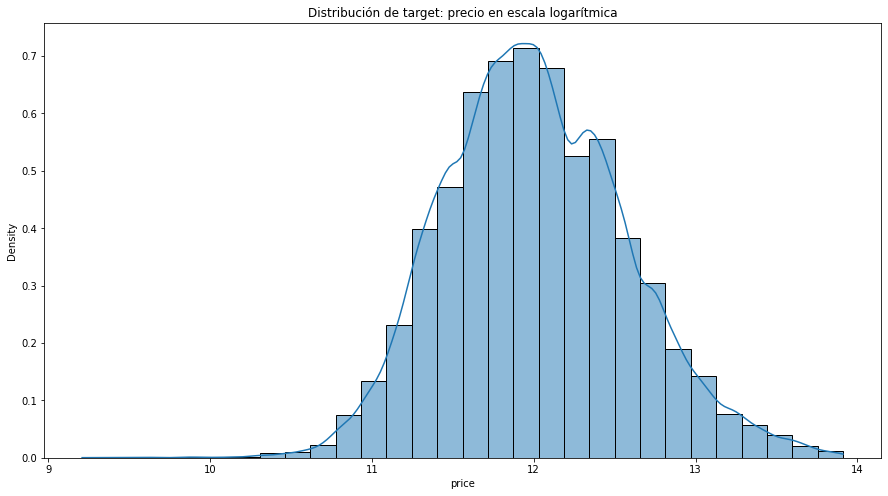

In [ ]:
sns.histplot((data.price), bins = 30, kde= True, stat="density")
plt.title('Distribución de target: precio en escala logarítmica')

## Probamos modelos del proyecto anterior


En la siguiente sección aplicamos tres modelos del primer proyecto. No optimizamos sus hiperparámetros. Utilizamos los mismos modelos en los nuevos dataset preprocesados previamente. Mostramos sus desempeños en train y en test con las métricas RECM, MAE y R2. Hacemos gráficos comparativos y asimismo comparamos con el desempeño del proyecto 1.

### Regresión lineal

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn import linear_model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['price'], axis = 1), data.price, test_size=0.33, random_state=42)

# Crear linear regression 
regr_lineal = linear_model.LinearRegression(normalize = True)

# Train the model 
regr_lineal.fit(X_train, y_train);

Creamos una función auxiliar para evaluar modelos. Imprime en pantalla los errores RECM, MAE y R2 para train y test. Muestra tres gráficos:
1. Residuos contra Predicciones (con logaritmo).
2. Histograma de errores en train y en test.
3. Precio en test contra precio predicho.

Además entrega un diccionario con los errores almacenados.

In [ ]:
def evaluar_regresion(model, X_train, X_test, y_train, y_test):
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    ### CALCULAMOS EL ERROR
    rmse_train = np.sqrt(mean_squared_error(np.exp(y_train), np.exp(y_train_pred)))
    rmse_test = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_test_pred)))
    mae_train = mean_absolute_error(np.exp(y_train), np.exp(y_train_pred))
    mae_test = mean_absolute_error(np.exp(y_test), np.exp(y_test_pred))
    r2_train = r2_score(np.exp(y_train), np.exp(y_train_pred))
    r2_test = r2_score(np.exp(y_test), np.exp(y_test_pred))
    print(str(model).upper())
    print("ERROR  TRAIN     TEST    ")
    print("------ --------  --------")
    print("%-6s %-9.2f %.2f "%('RECM:',rmse_train,rmse_test))
    print("%-6s %-9.2f %.2f "%('MAE:',mae_train,mae_test))
    print("%-10s %-9.2f %.2f "%('R2:',r2_train,r2_test))
    

    expy_train = np.exp(y_train)
    expy_train_pred = np.exp(y_train_pred)
    expy_test = np.exp(y_test)
    expy_test_pred = np.exp(y_test_pred)
    
    ### GRAFICAMOS LOS RESULTADOS
    plt.figure(figsize = (18,6))
    plt.subplot(1,3,1)
    residuos = y_test - y_test_pred
    
    plt.scatter(y_test_pred, residuos)
    plt.plot(y_test_pred,np.zeros(len(y_test_pred)),c='r')
    plt.xlabel('Predicciones (con log)')
    plt.ylabel('Residuos')
    

    plt.subplot(1,3,2)
    sns.histplot((expy_train - expy_train_pred), bins = 20, label = 'train', color='C2', kde= True, stat="density")
    sns.histplot((expy_test - expy_test_pred), bins = 20, label = 'test', color='C3', kde = True, stat="density")
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,3,3)
    ax.scatter(expy_test,expy_test_pred, s =2,c='C5')

    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')

    plt.tight_layout()
    plt.show();
    return {'RECM':[rmse_train,rmse_test], 'MAE':[mae_train,mae_test], 'R2':[r2_train,r2_test]}

LINEARREGRESSION(COPY_X=TRUE, FIT_INTERCEPT=TRUE, N_JOBS=NONE, NORMALIZE=TRUE)
ERROR  TRAIN     TEST    
------ --------  --------
RECM:  65796.06  65465.91 
MAE:   41377.36  41127.62 
R2:        0.74      0.74 


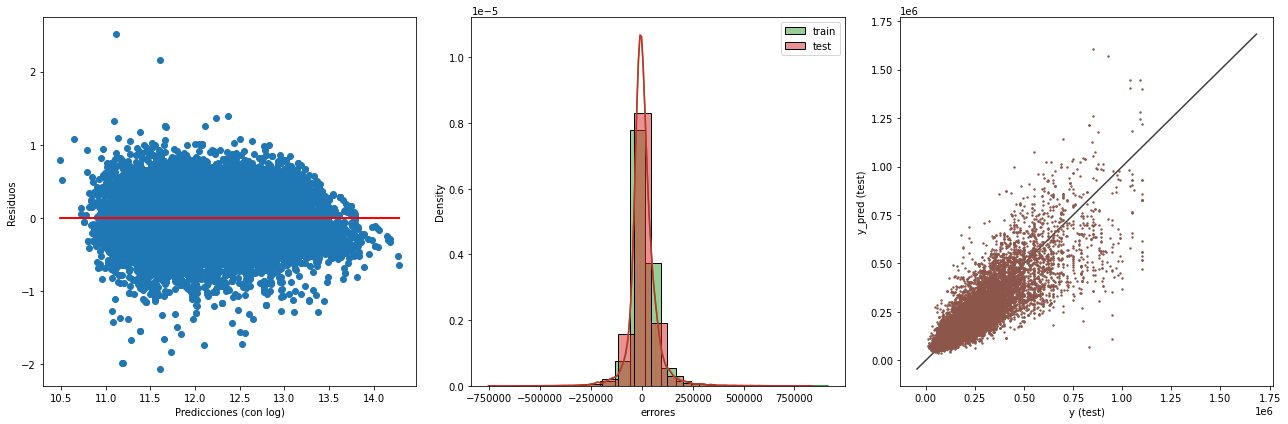

In [ ]:
errores_regr = evaluar_regresion(regr_lineal, X_train, X_test, y_train, y_test)

### 2-Vecinos más cercanos

Evaluar la regresión de 2-vecinos más cercanos en el dataset sin aplicar pca demora aproximadamente 150 segundos. Se puede evitar correr esta sub-sección. Igualmente dejo los gráficos presentados junto con el código comentado.

In [ ]:
#Create model
regr_2v = KNeighborsRegressor(2, n_jobs = -1)
    
#Train model
regr_2v.fit(X_train,y_train);

KNEIGHBORSREGRESSOR(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                    METRIC_PARAMS=NONE, N_JOBS=-1, N_NEIGHBORS=2, P=2,
                    WEIGHTS='UNIFORM')
ERROR  TRAIN     TEST    
------ --------  --------
RECM:  27761.55  51805.77 
MAE:   12576.36  26357.51 
R2:        0.95      0.84 


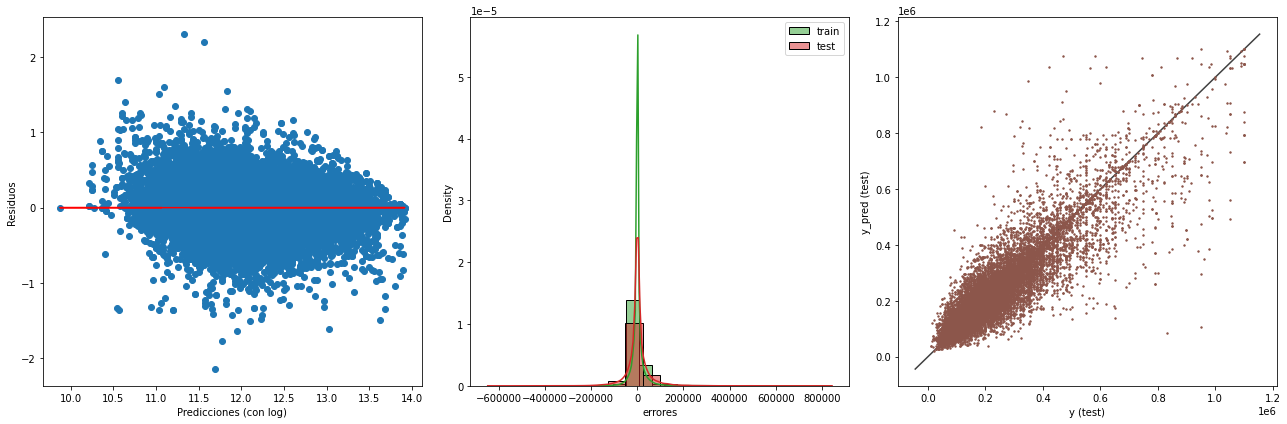

In [ ]:
errores_2v = evaluar_regresion(regr_2v, X_train, X_test, y_train, y_test)

### Árbol de desición

In [ ]:
#Crear modelo
clf_arbol = DecisionTreeRegressor(max_depth = 19, random_state = 42)

# Entrenar el modelo
clf_arbol.fit(X_train,y_train);

DECISIONTREEREGRESSOR(CCP_ALPHA=0.0, CRITERION='MSE', MAX_DEPTH=19,
                      MAX_FEATURES=NONE, MAX_LEAF_NODES=NONE,
                      MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
                      MIN_SAMPLES_LEAF=1, MIN_SAMPLES_SPLIT=2,
                      MIN_WEIGHT_FRACTION_LEAF=0.0, PRESORT='DEPRECATED',
                      RANDOM_STATE=42, SPLITTER='BEST')
ERROR  TRAIN     TEST    
------ --------  --------
RECM:  21846.21  48962.25 
MAE:   9134.68   24331.92 
R2:        0.97      0.85 


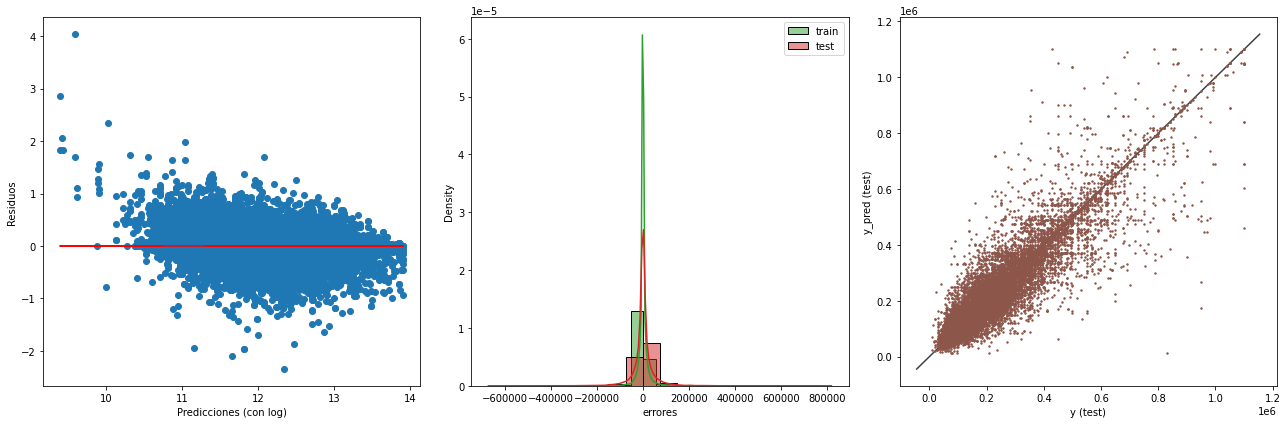

In [ ]:
errores_arbol = evaluar_regresion(clf_arbol, X_train, X_test, y_train, y_test)

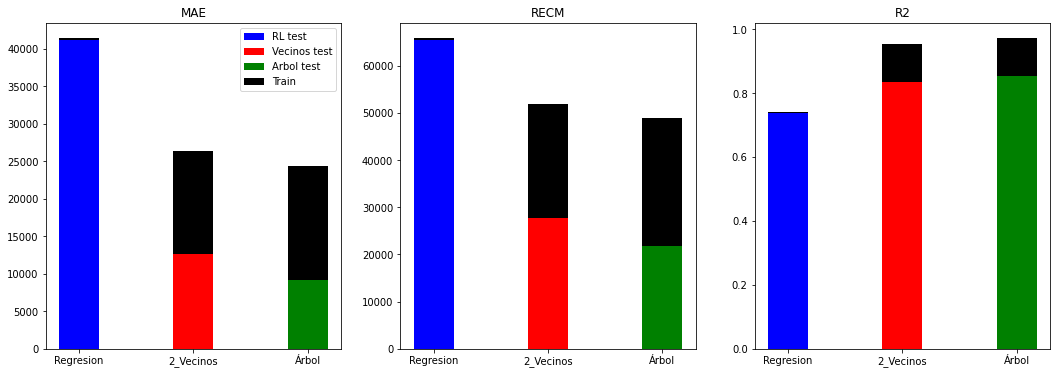

In [ ]:
mae = [errores_regr['MAE'][1],errores_2v['MAE'][1],errores_arbol['MAE'][1]]
recm = [errores_regr['RECM'][1],errores_2v['RECM'][1],errores_arbol['RECM'][1]]
r2 = [errores_regr['R2'][1],errores_2v['R2'][1],errores_arbol['R2'][1]]
mae_train = [errores_regr['MAE'][0]-errores_regr['MAE'][1], errores_2v['MAE'][0]-errores_2v['MAE'][1], errores_arbol['MAE'][0]-errores_arbol['MAE'][1]]
recm_train = [errores_regr['RECM'][0]-errores_regr['RECM'][1], errores_2v['RECM'][0]-errores_2v['RECM'][1], errores_arbol['RECM'][0]-errores_arbol['RECM'][1]]
r2_train = [errores_regr['R2'][0]-errores_regr['R2'][1], errores_2v['R2'][0]-errores_2v['R2'][1], errores_arbol['R2'][0]-errores_arbol['R2'][1]]
ticks_x =('Regresion', '2_Vecinos', 'Árbol')
color = ('b','r','g')
width = 0.35
x=np.arange(3)   
### GRAFICAMOS LOS RESULTADOS
plt.figure(figsize = (18,6))
plt.subplot(1,3,1)
p =plt.bar(x,mae,color=color,width=width)
p2 = plt.bar(x,mae_train,width=width,bottom=mae,color='k')
plt.legend((p[0],p[1],p[2],p2[0]), ('RL test','Vecinos test', 'Arbol test','Train'))
plt.title('MAE')
plt.xticks(x,ticks_x)
plt.subplot(1,3,2)
plt.bar(x,recm,color=color,width=width)
plt.bar(x,recm_train,width=width,bottom=recm,color='k')
plt.title('RECM')
plt.xticks(x,ticks_x)
plt.subplot(1,3,3)
plt.bar(x,r2,width=width,color=color)
plt.bar(x,r2_train,width=width,bottom=r2,color='k')
plt.title('R2')
plt.xticks(x,ticks_x)
plt.show()

In [ ]:
print('El precio promedio de las propiedades del dataset es: US$%.2f'%(np.exp(data.price).mean()))

El precio promedio de las propiedades del dataset es: US$195208.90


In [ ]:
l1=[errores_regr[key][0].round(2) for key in errores_regr.keys()]
l2=[errores_2v[key][0].round(2) for key in errores_2v.keys()]
l3=[errores_arbol[key][0].round(2) for key in errores_arbol.keys()]
names=['Regresión', '2-vecinos', 'Árbol']
df_errores_train = pd.DataFrame(np.array([l1,l2,l3]), columns=['RECM','MAE','R2'])
df_errores_train.insert(0,'Regresor',names,True)
print('Errores en train')
print(df_errores_train)
l1=[errores_regr[key][1].round(2) for key in errores_regr.keys()]
l2=[errores_2v[key][1].round(2) for key in errores_2v.keys()]
l3=[errores_arbol[key][1].round(2) for key in errores_arbol.keys()]
names=['Regresión', '2-vecinos', 'Árbol']
df_errores_test = pd.DataFrame(np.array([l1,l2,l3]), columns=['RECM','MAE','R2'])
df_errores_test.insert(0,'Regresor',names,True)
print('Errores en test')
print(df_errores_test)

Errores en train
    Regresor      RECM       MAE    R2
0  Regresión  65796.06  41377.36  0.74
1  2-vecinos  27761.55  12576.36  0.95
2      Árbol  21846.21   9134.68  0.97
Errores en test
    Regresor      RECM       MAE    R2
0  Regresión  65465.91  41127.62  0.74
1  2-vecinos  51805.77  26357.51  0.84
2      Árbol  48962.25  24331.92  0.85


Podemos observar que el modelo de árbol de decisión tiene el mejor desempeño en test en las tres métricas estudiadas. Además mejora ampliamente los desempeños del proyecto 1. Recordemos que en el primer proyecto nuestro mejor modelo obtuvo un desempeño de US\$135073 para RECM en test. En este caso, el error RECM en test para el modelo de árbol de decisión es de US\$48962.25. Observamos además que el error MAE en test para el modelo de árbol desciende a US\$24331.92. Estamos hablando de un error de predicción promedio de alrededor del 12% (el precio promedio de las propiedades de nuestro dataset es de US\$195208.90). Sin embargo, la diferencia entre el desempeño en train y en test es considerablemente alta por que lo que podemos decir que estamos en una situación de overfitting que intentaremos mejorar en la próxima sección. A continuación realizamos el mismo trabajo en el dataset con reducción dimensional.

Text(0, 0.5, 'MAE')

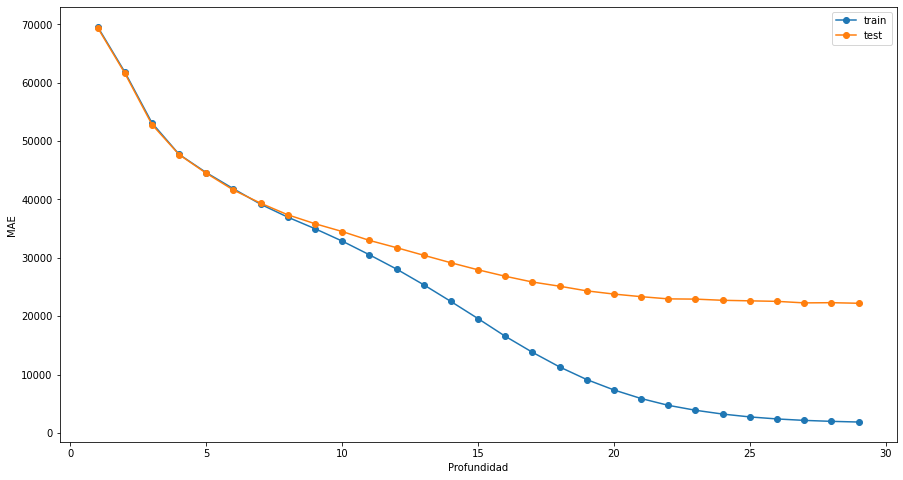

In [ ]:
#Optimización de 1 hiperparámetro para el árbol de decisión
profundidad = range(1, 30)
# Definimos las listas vacias para los valores de accuracy deseados
lista_recm_train_a = []
lista_recm_test_a = []
# Generamos en loop sobre los distintos valores de k 
for p in profundidad:
    
    # Vamos a repetir el siguiente bloque de código
    
    # Definir el modelo con el valor de vecinos deseado
    clf = DecisionTreeRegressor(max_depth = p, random_state = 42)
    
    # Entrenar el modelo
    clf.fit(X_train,y_train)
    
    # Predecir y evaluar sobre el set de entrenamiento
    y_train_pred = clf.predict(X_train)
    train_recm = mean_absolute_error(np.exp(y_train), np.exp(y_train_pred))
    
    # Predecir y evaluar sobre el set de evaluación
    y_test_pred = clf.predict(X_test)
    test_recm = mean_absolute_error(np.exp(y_test), np.exp(y_test_pred))
    
    # Agregar la información a las listas
    lista_recm_train_a.append(train_recm)
    lista_recm_test_a.append(test_recm)

plt.plot(profundidad, lista_recm_train_a,'o-', label='train')
plt.plot(profundidad, lista_recm_test_a, 'o-', label='test' )
plt.legend()
plt.xlabel('Profundidad')
plt.ylabel('MAE')

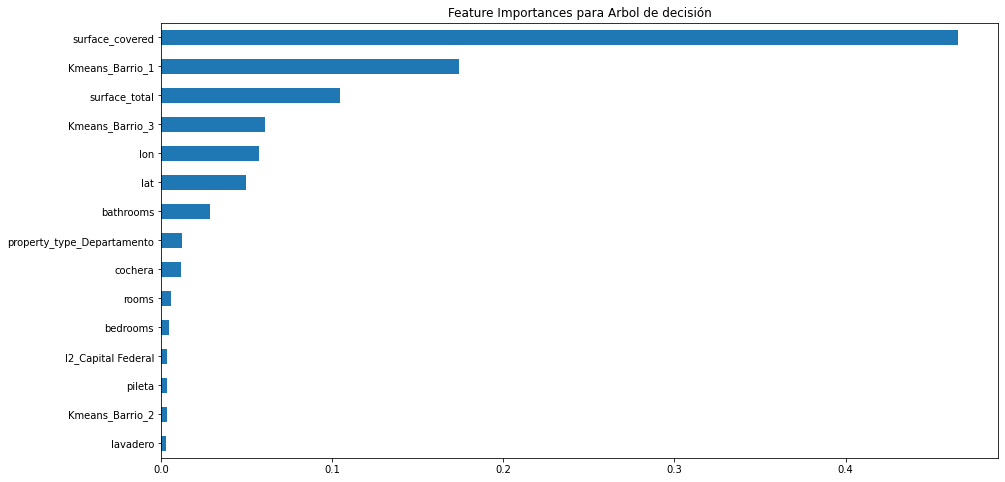

In [ ]:
feat_importances = pd.Series(clf_arbol.feature_importances_, index=[str(col) for col in data.columns if col!='price'])
feat_importances.nlargest(15).plot(kind='barh').invert_yaxis()
plt.title('Feature Importances para Arbol de decisión')
plt.show()

### PCA:


Vemos que tarda demasiado tiempo en maquina en correr bloques de código, por ejemplo KNN para el dataset de 27 features. Probamos los mismos modelos con el dataset PCA con reducción dimensional. 

In [ ]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(data_pca.drop(['price'], axis = 1), data_pca.price, test_size=0.33, random_state=42)

regr_lineal_pca = linear_model.LinearRegression()

# Train the model 
regr_lineal_pca.fit(X_train_pca, y_train_pca);

LINEARREGRESSION(COPY_X=TRUE, FIT_INTERCEPT=TRUE, N_JOBS=NONE, NORMALIZE=FALSE)
ERROR  TRAIN     TEST    
------ --------  --------
RECM:  79086.76  78509.11 
MAE:   47305.20  46925.07 
R2:        0.62      0.62 


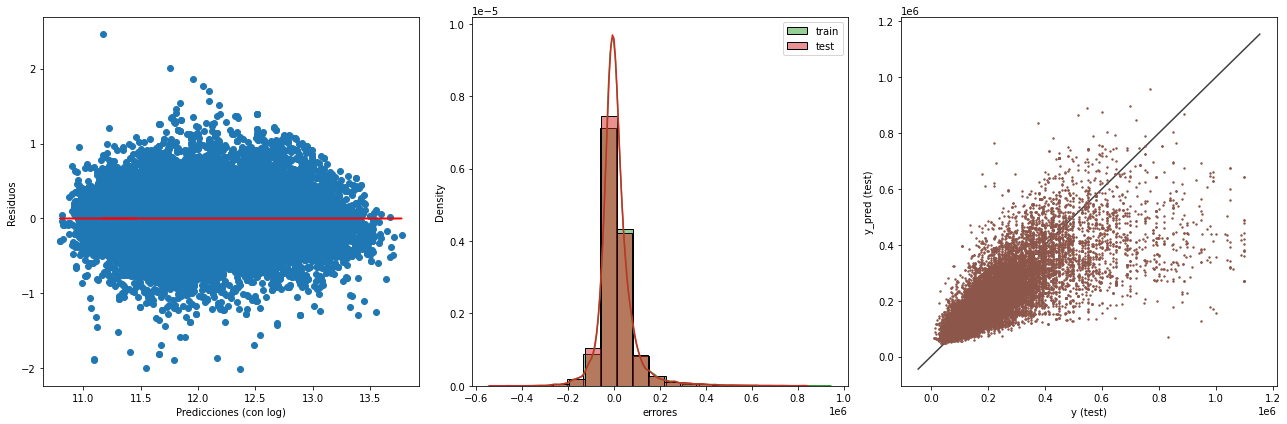

In [ ]:
errores_regr_pca = evaluar_regresion(regr_lineal_pca, X_train_pca, X_test_pca, y_train_pca, y_test_pca)

In [ ]:
clf_2v_pca = KNeighborsRegressor(2)
    
# Entrenar el modelo
clf_2v_pca.fit(X_train_pca, y_train_pca)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

KNEIGHBORSREGRESSOR(ALGORITHM='AUTO', LEAF_SIZE=30, METRIC='MINKOWSKI',
                    METRIC_PARAMS=NONE, N_JOBS=NONE, N_NEIGHBORS=2, P=2,
                    WEIGHTS='UNIFORM')
ERROR  TRAIN     TEST    
------ --------  --------
RECM:  28987.87  54535.04 
MAE:   13034.71  27475.72 
R2:        0.95      0.82 


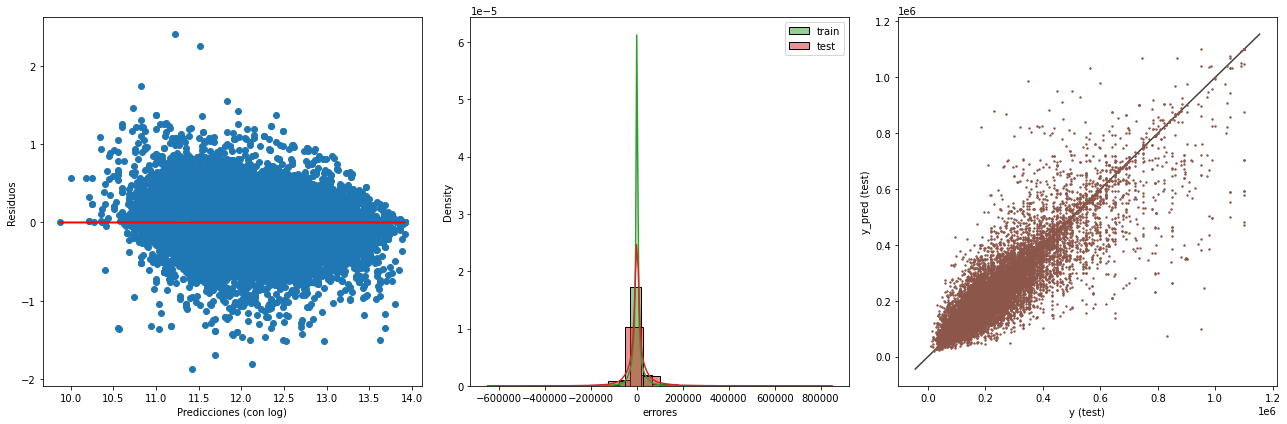

In [ ]:
errores_2v_pca = evaluar_regresion(clf_2v_pca,X_train_pca, X_test_pca, y_train_pca, y_test_pca)

In [ ]:
clf_arbol_pca = DecisionTreeRegressor(max_depth = 10)
# Entrenar el modelo
clf_arbol_pca.fit(X_train_pca, y_train_pca)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DECISIONTREEREGRESSOR(CCP_ALPHA=0.0, CRITERION='MSE', MAX_DEPTH=10,
                      MAX_FEATURES=NONE, MAX_LEAF_NODES=NONE,
                      MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
                      MIN_SAMPLES_LEAF=1, MIN_SAMPLES_SPLIT=2,
                      MIN_WEIGHT_FRACTION_LEAF=0.0, PRESORT='DEPRECATED',
                      RANDOM_STATE=NONE, SPLITTER='BEST')
ERROR  TRAIN     TEST    
------ --------  --------
RECM:  60168.59  65665.43 
MAE:   36828.02  39532.52 
R2:        0.78      0.74 


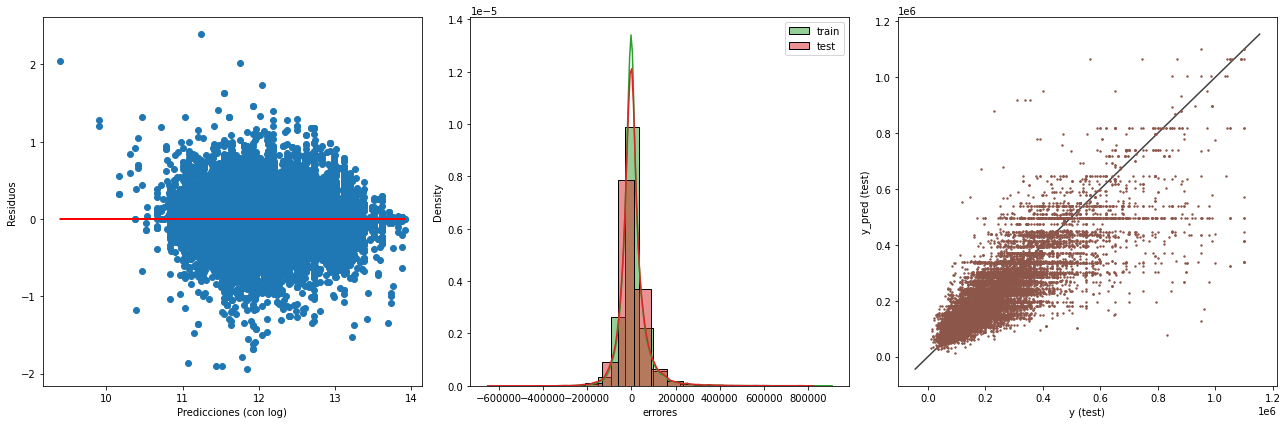

In [ ]:
errores_arbol_pca = evaluar_regresion(clf_arbol_pca,X_train_pca, X_test_pca, y_train_pca, y_test_pca)

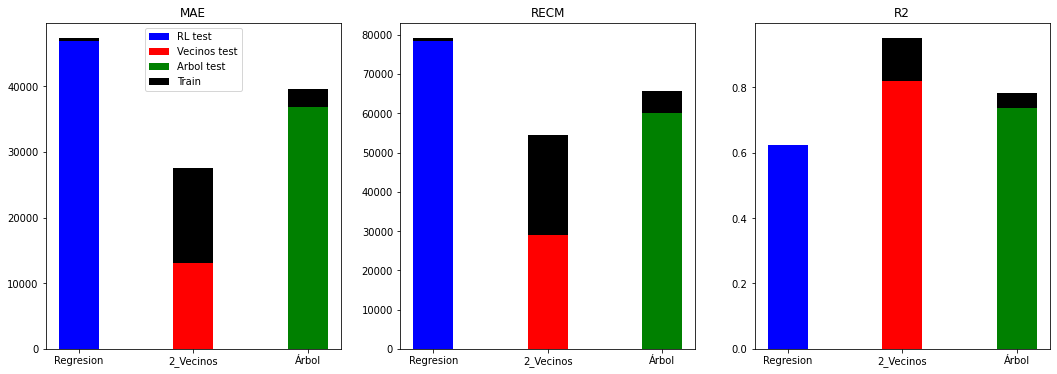

In [ ]:
mae_pca = [errores_regr_pca['MAE'][1],errores_2v_pca['MAE'][1],errores_arbol_pca['MAE'][1]]
recm_pca = [errores_regr_pca['RECM'][1],errores_2v_pca['RECM'][1],errores_arbol_pca['RECM'][1]]
r2_pca = [errores_regr_pca['R2'][1],errores_2v_pca['R2'][1],errores_arbol_pca['R2'][1]]
mae_pca_train = [errores_regr_pca['MAE'][0]-errores_regr_pca['MAE'][1], errores_2v_pca['MAE'][0]-errores_2v_pca['MAE'][1], errores_arbol_pca['MAE'][0]-errores_arbol_pca['MAE'][1]]
recm_pca_train = [errores_regr_pca['RECM'][0]-errores_regr_pca['RECM'][1], errores_2v_pca['RECM'][0]-errores_2v_pca['RECM'][1], errores_arbol_pca['RECM'][0]-errores_arbol_pca['RECM'][1]]
r2_pca_train = [errores_regr_pca['R2'][0]-errores_regr_pca['R2'][1], errores_2v_pca['R2'][0]-errores_2v_pca['R2'][1], errores_arbol_pca['R2'][0]-errores_arbol_pca['R2'][1]]
ticks_x =('Regresion', '2_Vecinos', 'Árbol')
color = ('b','r','g')
width = 0.35   
### GRAFICAMOS LOS RESULTADOS
plt.figure(figsize = (18,6))
plt.subplot(1,3,1)
p =plt.bar(x,mae_pca,color=color,width=width)
p2 = plt.bar(x,mae_pca_train,width=width,bottom=mae_pca,color='k')
plt.legend((p[0],p[1],p[2],p2[0]), ('RL test','Vecinos test', 'Arbol test','Train'))
plt.title('MAE')
plt.xticks(x,ticks_x)
plt.subplot(1,3,2)
plt.bar(x,recm_pca,color=color,width=width)
plt.bar(x,recm_pca_train,width=width,bottom=recm_pca,color='k')
plt.title('RECM')
plt.xticks(x,ticks_x)
plt.subplot(1,3,3)
plt.bar(x,r2_pca,width=width,color=color)
plt.bar(x,r2_pca_train,width=width,bottom=r2_pca,color='k')
plt.title('R2')
plt.xticks(x,ticks_x)
plt.show()

2-vecinos más cercanos tiene mejor performance en test para el dataset con reducción dimansional en las tres métrcias analizadas. Todas las veces que evaluamos regresiones en el primero de los gráficos observamos que aún queda estructura en los residuos con logaritmo, no se observa ruido real. En las puntas (propiedades de valor bajo o alto) los gráficos aparentan 'redondeados'. Las distribuciones en train y en test de los errores son similares, aunque los errores en train son más concentrados entorno al cero. En el tercero de los gráficos podemos observar que nuestros modelos tienen alta dispersión para precios altos. Una estrategia en un futuro podria ser truncar el dataset a propiedades cuyos precios reales no superen por ejemplo US\$600.000 o US\$800.000.

# PARTE B - Modelos Avanzados

1. Elige dos de los modelos avanzados vistos Compara con el desempeño obtenido en el proyecto 01 (en el caso de regresión, considera una regresión lineal con atributos polinómicos y regularización). Entrénalos y evalúalos con sus argumentos por defecto. No te olvides de hacer un train/test split y usar Validación Cruzada.
2. Optimiza sus hiperparámetros mediante Validación Cruzada y Grid Search o Random Search.
3. Compara el desempeño de los nuevos modelos entre sí y con el modelo de la Parte A. ¿Cuál elegirías? Justifica.

## Regresión lineal con atributos polinómicos y regularización


Hacemos regresión lineal con atributos polinómicos. Aplicamos regularización de tipo Lasso y validación cruzada con 5 particiones. Usamos nuesto dataset con reducción dimensional para mejorar los tiempos.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
Xpoly =  data_pca.drop(['price'],axis = 1)
ypoly =  data_pca.price

poly2 = PolynomialFeatures(degree = 2)
X2poly = poly2.fit_transform(Xpoly)

X2poly_train, X2poly_test, y2poly_train, y2poly_test = train_test_split(X2poly, ypoly, test_size=0.25, random_state=42)

reg_lasso = Lasso(alpha = 0.001)
print('Scores en train para cross-validation:')
scores = cross_val_score(reg_lasso, X2poly_train, y2poly_train, cv=5, scoring='r2', n_jobs = -1)
scores


Scores en train para cross-validation:


array([0.7256626 , 0.72711826, 0.7179082 , 0.71978578, 0.72707362])

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 1
Agregamos atributos hasta la potencia 1
Scores en train para cross-validation:
[0.69566479 0.70212764 0.68772561 0.69446027 0.69888952]
LASSO(ALPHA=0.001, COPY_X=TRUE, FIT_INTERCEPT=TRUE, MAX_ITER=1000,
      NORMALIZE=FALSE, POSITIVE=FALSE, PRECOMPUTE=FALSE, RANDOM_STATE=NONE,
      SELECTION='CYCLIC', TOL=0.0001, WARM_START=FALSE)
ERROR  TRAIN     TEST    
------ --------  --------
RECM:  79037.21  78965.77 
MAE:   47150.02  46914.48 
R2:        0.62      0.62 


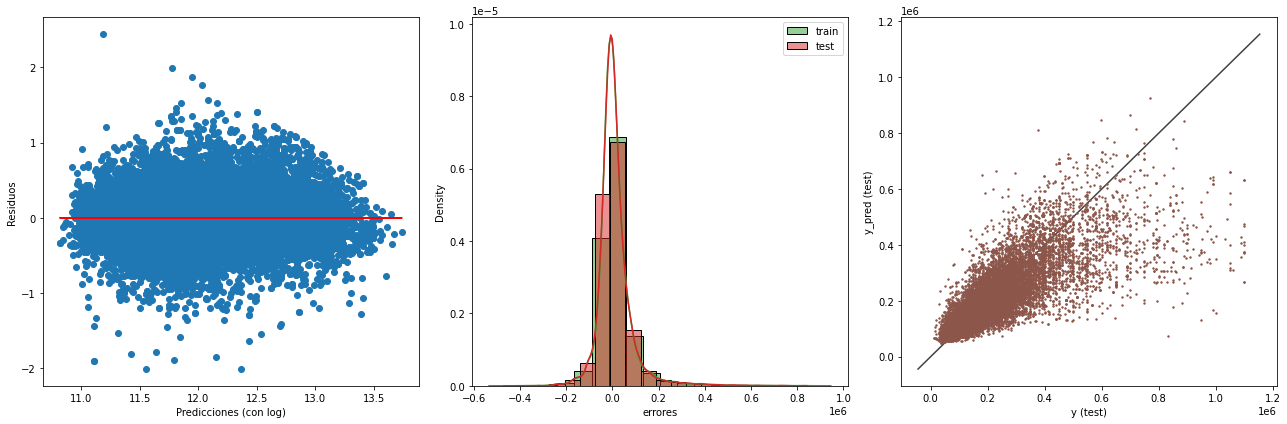

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 2
Agregamos atributos hasta la potencia 2
Scores en train para cross-validation:
[0.7256626  0.72711826 0.7179082  0.71978578 0.72707362]
LASSO(ALPHA=0.001, COPY_X=TRUE, FIT_INTERCEPT=TRUE, MAX_ITER=1000,
      NORMALIZE=FALSE, POSITIVE=FALSE, PRECOMPUTE=FALSE, RANDOM_STATE=NONE,
      SELECTION='CYCLIC', TOL=0.0001, WARM_START=FALSE)
ERROR  TRAIN     TEST    
------ --------  --------
RECM:  75170.01  75202.37 
MAE:   44845.30  44655.75 
R2:        0.66      0.66 


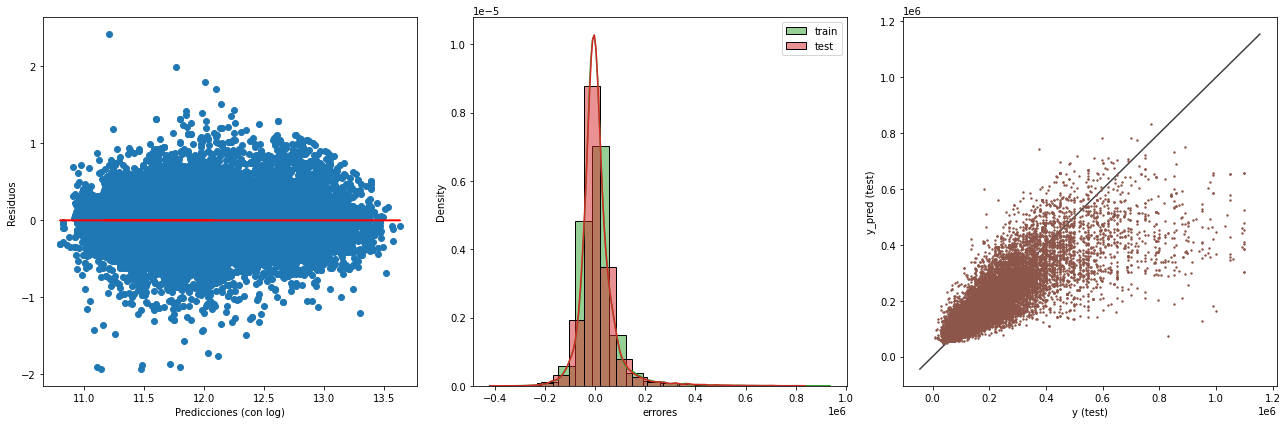

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 3
Agregamos atributos hasta la potencia 3
Scores en train para cross-validation:


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[0.72806058 0.72897072 0.72001213 0.72147295 0.72883406]
LASSO(ALPHA=0.001, COPY_X=TRUE, FIT_INTERCEPT=TRUE, MAX_ITER=1000,
      NORMALIZE=FALSE, POSITIVE=FALSE, PRECOMPUTE=FALSE, RANDOM_STATE=NONE,
      SELECTION='CYCLIC', TOL=0.0001, WARM_START=FALSE)
ERROR  TRAIN     TEST    
------ --------  --------
RECM:  74702.67  74719.27 
MAE:   44731.75  44521.19 
R2:        0.66      0.66 


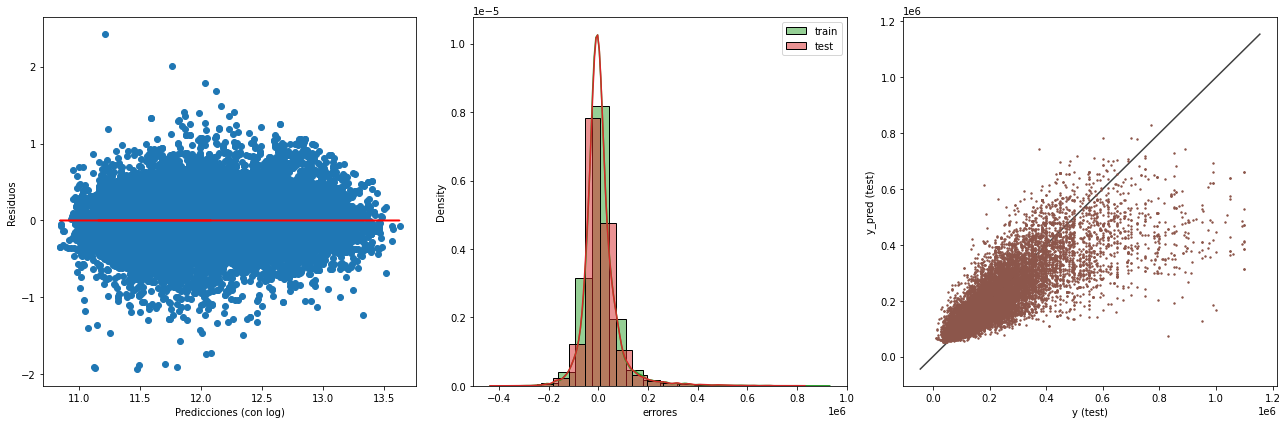

In [ ]:
for idx,potencia in enumerate(range(1,4)):
    print(f'REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO {idx + 1}')
    print(f'Agregamos atributos hasta la potencia {potencia}')
    
    polyk = PolynomialFeatures(degree = potencia)
    Xkpoly = polyk.fit_transform(Xpoly)
    
    X_polyk_train, X_polyk_test, y_polyk_train, y_polyk_test = train_test_split(
        Xkpoly, ypoly, test_size=0.25, random_state=42)
    print('Scores en train para cross-validation:')
    scores = cross_val_score(reg_lasso, X_polyk_train, y_polyk_train, cv=5, scoring='r2', n_jobs = -1)
    print(scores)
    reg_lasso.fit(X_polyk_train, y_polyk_train)
    
    evaluar_regresion(reg_lasso, X_polyk_train, X_polyk_test, y_polyk_train, y_polyk_test)
    

Podemos observar una mejora de grado 1 a grado 2 y luego a partir de grado 2 los errores se matienen constantes a medida que crece el grado. Por lo tanto, continuamos trabajando con grado 2.

In [ ]:
#Predecimos en los datos de test
reg_lasso.fit(X2poly_train,y2poly_train)
predictionpoly = reg_lasso.predict(X2poly_test)

In [ ]:
print('Regresión atributos polinomiales grado 2 con regularización Lasso:')
print('RECM:', np.sqrt(mean_squared_error(np.exp(y2poly_test) , np.exp(predictionpoly))).round(3))
print('MAE:', mean_absolute_error(np.exp(y2poly_test) , np.exp(predictionpoly)).round(3))
print('R2:', r2_score(np.exp(y2poly_test) , np.exp(predictionpoly)).round(3))

Regresión atributos polinomiales grado 2 con regularización Lasso:
RECM: 75202.369
MAE: 44655.752
R2: 0.659


Mejoramos el desempeño con grid search:

In [ ]:
import scipy as sp
#from sklearn.metrics import classification_report
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
#from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
# Grilla para Grid Search
param_grid = {'alpha':[0.00001,0.0001], 'tol':[0.2,0.1], 'max_iter':[1000,2000,5000]}
#'selection':['cyclic', 'random'], 'random_state':[1,42,1999]

In [ ]:
#ESTRATEGIA: Grid Search
reg_lasso_gs = Lasso()
model = GridSearchCV(reg_lasso_gs, param_grid=param_grid, cv=5, scoring='r2', n_jobs = -1)

# Entrenamos: KNN con la grilla definida arriba y CV con tamaño de Fold=5
model.fit(X2poly_train, y2poly_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0001],
                         'max_iter': [1000, 2000, 5000], 'tol': [0.2, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [ ]:
print("Mejores parametros: "+str(model.best_params_))
print("Mejor Score: %.4f"%(model.best_score_) + '\n')

scores = pd.DataFrame(model.cv_results_)
scores

Mejores parametros: {'alpha': 1e-05, 'max_iter': 1000, 'tol': 0.1}
Mejor Score: 0.7886



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,param_tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.182589,0.048948,0.005264,0.001260,1e-05,1000,0.2,"{'alpha': 1e-05, 'max_iter': 1000, 'tol': 0.2}",0.729933,0.729766,0.721397,0.724482,0.731384,0.727392,0.003806,7
1,20.570587,0.997423,0.007082,0.000116,1e-05,1000,0.1,"{'alpha': 1e-05, 'max_iter': 1000, 'tol': 0.1}",0.789864,0.788767,0.783153,0.785541,0.795640,0.788593,0.004248,1
2,0.241668,0.005397,0.006985,0.000166,1e-05,2000,0.2,"{'alpha': 1e-05, 'max_iter': 2000, 'tol': 0.2}",0.729933,0.729766,0.721397,0.724482,0.731384,0.727392,0.003806,7
3,20.664553,1.004098,0.007095,0.000194,1e-05,2000,0.1,"{'alpha': 1e-05, 'max_iter': 2000, 'tol': 0.1}",0.789864,0.788767,0.783153,0.785541,0.795640,0.788593,0.004248,1
4,0.237209,0.004607,0.007041,0.000164,1e-05,5000,0.2,"{'alpha': 1e-05, 'max_iter': 5000, 'tol': 0.2}",0.729933,0.729766,0.721397,0.724482,0.731384,0.727392,0.003806,7
5,20.776325,1.004101,0.007274,0.000320,1e-05,5000,0.1,"{'alpha': 1e-05, 'max_iter': 5000, 'tol': 0.1}",0.789864,0.788767,0.783153,0.785541,0.795640,0.788593,0.004248,1
6,0.241816,0.004429,0.007097,0.000283,0.0001,1000,0.2,"{'alpha': 0.0001, 'max_iter': 1000, 'tol': 0.2}",0.729517,0.729562,0.720933,0.724054,0.730778,0.726969,0.003812,10
7,4.880359,0.127145,0.007123,0.000109,0.0001,1000,0.1,"{'alpha': 0.0001, 'max_iter': 1000, 'tol': 0.1}",0.771727,0.770267,0.763166,0.765478,0.775366,0.769201,0.004378,4
8,0.237350,0.004920,0.006938,0.000156,0.0001,2000,0.2,"{'alpha': 0.0001, 'max_iter': 2000, 'tol': 0.2}",0.729517,0.729562,0.720933,0.724054,0.730778,0.726969,0.003812,10
9,4.905067,0.113163,0.007212,0.000270,0.0001,2000,0.1,"{'alpha': 0.0001, 'max_iter': 2000, 'tol': 0.1}",0.771727,0.770267,0.763166,0.765478,0.775366,0.769201,0.004378,4


In [ ]:
#Predecimos en los datos de test
prediction2 = model.predict(X2poly_test)

In [ ]:
print('Errores Test para Grid Search en regresión con atributos polinomiales de grado 2 con regularización Lasso:')
print('RECM:', np.sqrt(mean_squared_error(np.exp(y2poly_test) , np.exp(prediction2))).round(3))
print('MAE:', mean_absolute_error(np.exp(y2poly_test) , np.exp(prediction2)).round(3))
print('R2:', r2_score(np.exp(y2poly_test) , np.exp(prediction2)).round(3))

Errores Test para Grid Search en regresión con atributos polinomiales de grado 2 con regularización Lasso:
RECM: 60971.496
MAE: 38038.133
R2: 0.776


## Random Forest

In [ ]:
# Importar modelo 
from sklearn.ensemble import RandomForestRegressor
# Instancio modelo con 100 decision trees
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
#Entrenar
rf.fit(X_train,y_train);

RANDOMFORESTREGRESSOR(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CRITERION='MSE',
                      MAX_DEPTH=NONE, MAX_FEATURES='AUTO', MAX_LEAF_NODES=NONE,
                      MAX_SAMPLES=NONE, MIN_IMPURITY_DECREASE=0.0,
                      MIN_IMPURITY_SPLIT=NONE, MIN_SAMPLES_LEAF=1,
                      MIN_SAMPLES_SPLIT=2, MIN_WEIGHT_FRACTION_LEAF=0.0,
                      N_ESTIMATORS=100, N_JOBS=NONE, OOB_SCORE=FALSE,
                      RANDOM_STATE=42, VERBOSE=0, WARM_START=FALSE)
ERROR  TRAIN     TEST    
------ --------  --------
RECM:  16127.02  37581.90 
MAE:   8111.77   19198.20 
R2:        0.98      0.91 


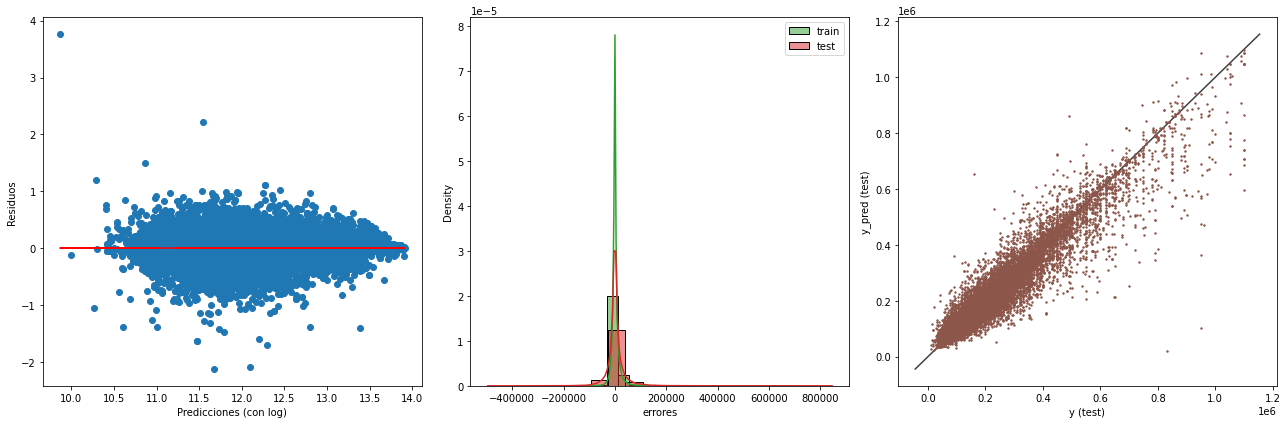

In [ ]:
errores_rf = evaluar_regresion(rf, X_train, X_test, y_train, y_test)

RANDOMFORESTREGRESSOR(BOOTSTRAP=TRUE, CCP_ALPHA=0.0, CRITERION='MSE',
                      MAX_DEPTH=14, MAX_FEATURES='AUTO', MAX_LEAF_NODES=NONE,
                      MAX_SAMPLES=NONE, MIN_IMPURITY_DECREASE=0.0,
                      MIN_IMPURITY_SPLIT=NONE, MIN_SAMPLES_LEAF=1,
                      MIN_SAMPLES_SPLIT=2, MIN_WEIGHT_FRACTION_LEAF=0.0,
                      N_ESTIMATORS=100, N_JOBS=NONE, OOB_SCORE=FALSE,
                      RANDOM_STATE=NONE, VERBOSE=0, WARM_START=FALSE)
ERROR  TRAIN     TEST    
------ --------  --------
RECM:  36772.12  44811.09 
MAE:   21210.10  25984.51 
R2:        0.92      0.88 


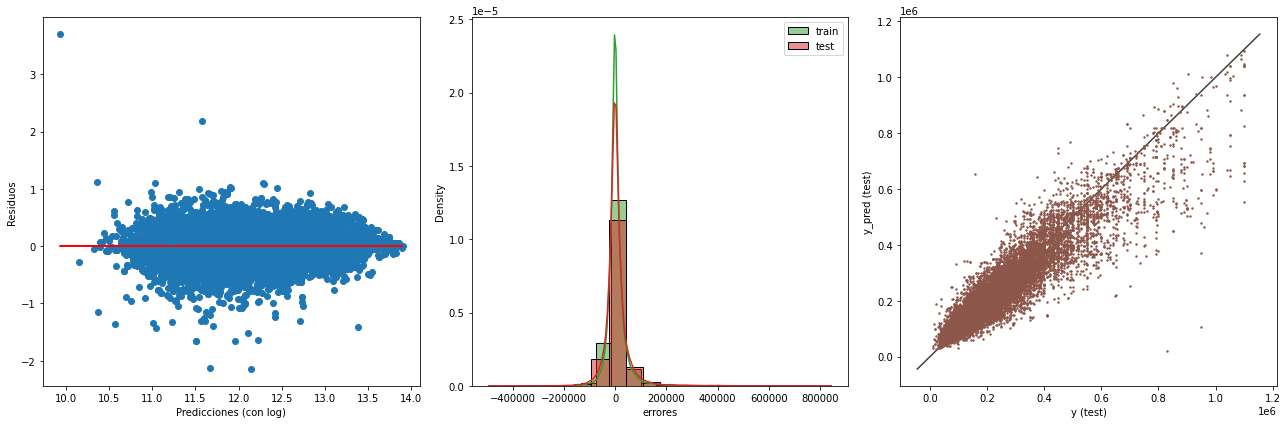

In [ ]:
# Notamos que esta un poco over fitteado, intentamos regularizar el modelo determinando max_depth
# Instancio modelo con max_depth=14
rf_ = RandomForestRegressor(max_depth=14)
#Entrenar
rf_.fit(X_train,y_train);
errores_rf = evaluar_regresion(rf_, X_train, X_test, y_train, y_test)

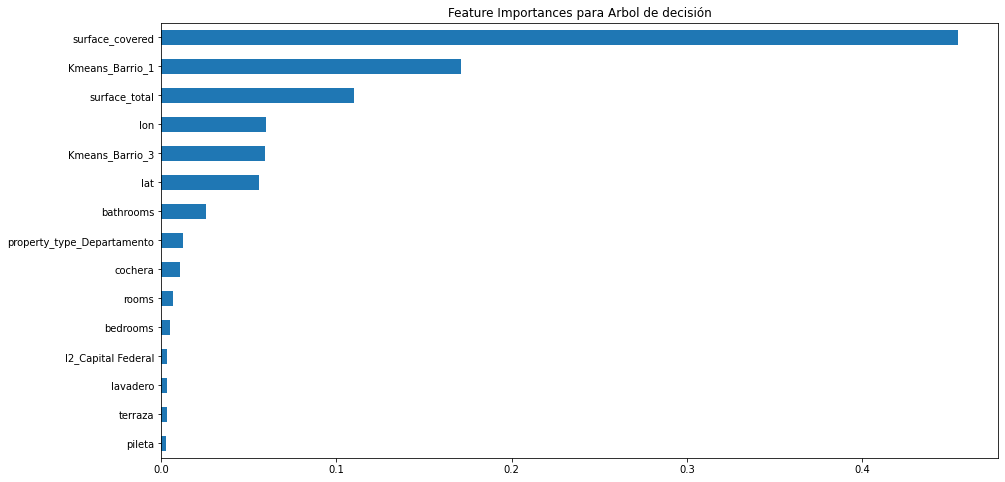

In [ ]:
feat_importances = pd.Series(rf.feature_importances_, index=[str(col) for col in data.columns if col!='price'])
feat_importances.nlargest(15).plot(kind='barh').invert_yaxis()
plt.title('Feature Importances para Arbol de decisión')
plt.show()

Realizamos una optimización de hiperparámetros usando Random Search y Cross Validation.

{'n_estimators': [200, 1000]}
fittteando....
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 14.0min finished


Fiteado!!!
{'n_estimators': 1000}
RANDOMIZEDSEARCHCV(CV=3, ERROR_SCORE=NAN,
                   ESTIMATOR=RANDOMFORESTREGRESSOR(BOOTSTRAP=TRUE,
                                                   CCP_ALPHA=0.0,
                                                   CRITERION='MSE',
                                                   MAX_DEPTH=NONE,
                                                   MAX_FEATURES='AUTO',
                                                   MAX_LEAF_NODES=NONE,
                                                   MAX_SAMPLES=NONE,
                                                   MIN_IMPURITY_DECREASE=0.0,
                                                   MIN_IMPURITY_SPLIT=NONE,
                                                   MIN_SAMPLES_LEAF=1,
                                                   MIN_SAMPLES_SPLIT=2,
                                                   MIN_WEIGHT_FRACTION_LEAF=0.0,
                                                   N_ESTIMATORS=1

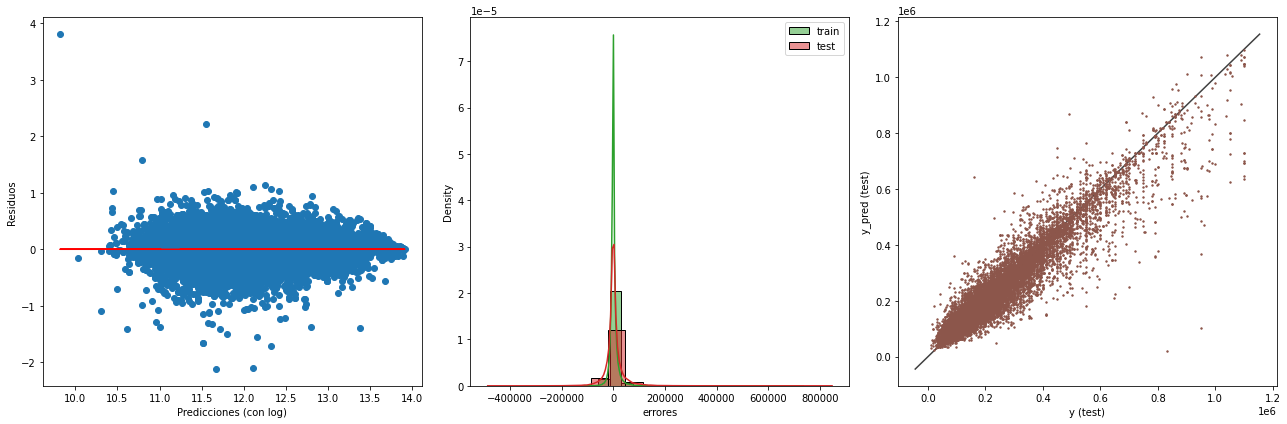

In [ ]:
#ESTRATEGIA: Random Search
rf0 = RandomForestRegressor()

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 2)]
# Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(20, 110, num = 11)]
# max_depth.append(None)
# Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
# bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators}
              # 'max_features': max_features,
              # 'max_depth': max_depth,
              # 'min_samples_split': min_samples_split,
              # 'min_samples_leaf': min_samples_leaf,
              # 'bootstrap': bootstrap}
print(random_grid)
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf0, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, random_state=42, n_jobs = -1) 
print('fittteando....')
# Fit the random search model
rf_random.fit(X_train, y_train)
print('Fiteado!!!')
print(rf_random.best_params_)


errores_rf_random = evaluar_regresion(rf_random, X_train, X_test, y_train, y_test)



## XGboost

In [ ]:
import xgboost as xgb

In [ ]:
X_train_xgb1, X_test_xgb1 = train_test_split(data, test_size=.3, random_state=1999)

In [ ]:
X_train_xgb = xgb.DMatrix(X_train_xgb1.drop(['price'], axis= 1), label=X_train_xgb1['price'])
X_test_xgb = xgb.DMatrix(X_test_xgb1.drop(['price'], axis = 1), label=X_test_xgb1['price'])

In [ ]:
X_train_xgb

In [ ]:
parametros = {"booster":"gbtree", "max_depth": 50, "eta": 0.4, "nthread":3}
rondas = 20

In [ ]:
modelo = xgb.train(parametros, X_train_xgb, rondas)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


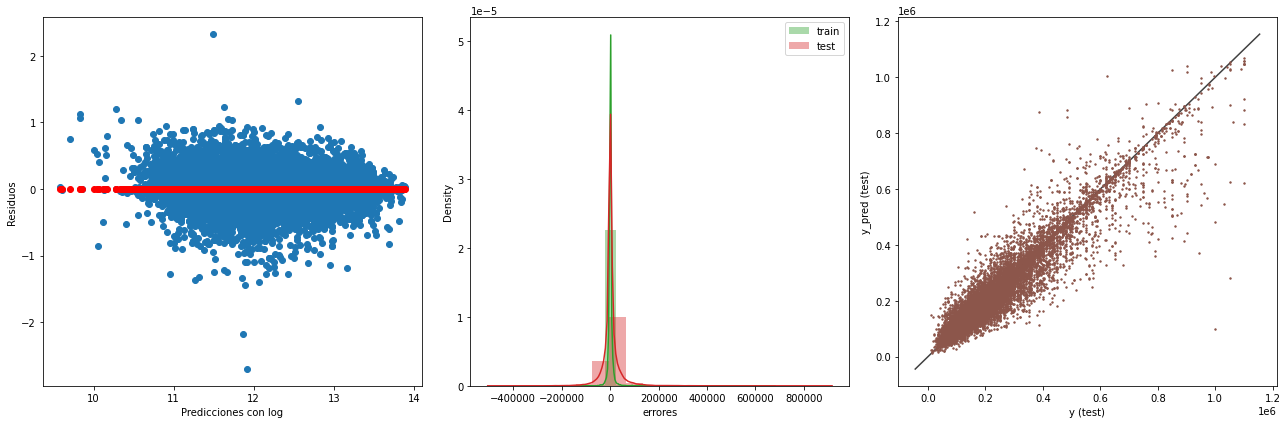

In [ ]:
prediccion = modelo.predict(X_test_xgb)
prediccion_train = modelo.predict(X_train_xgb)
expy_train = np.exp(X_train_xgb1['price'])
expy_train_pred = np.exp(prediccion_train)
expy_test = np.exp(X_test_xgb1['price'])
expy_test_pred = np.exp(prediccion)

### GRAFICAMOS LOS RESULTADOS
plt.figure(figsize = (18,6))
plt.subplot(1,3,1)
residuals_xgb = X_test_xgb1['price']-prediccion

plt.scatter(prediccion, residuals_xgb)
plt.scatter(prediccion, np.zeros(len(prediccion)),c='r')
plt.xlabel('Predicciones con log')
plt.ylabel('Residuos')
   
# stat="density"
plt.subplot(1,3,2)
sns.distplot((expy_train - expy_train_pred), bins = 20, label = 'train', color='C2', kde= True)
sns.distplot((expy_test - expy_test_pred), bins = 20, label = 'test', color='C3', kde = True)
plt.xlabel('errores')
plt.legend()

ax = plt.subplot(1,3,3)
ax.scatter(expy_test,expy_test_pred, s =2,c='C5')

lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
       ]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

plt.tight_layout()
plt.show();

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


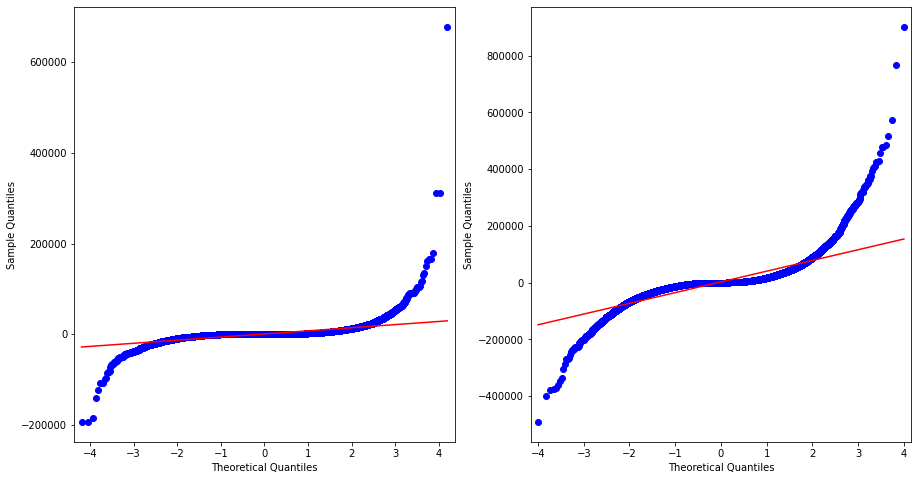

In [ ]:
import statsmodels.api as sm
import pylab
fig, (ax, ax2) = plt.subplots(ncols=2) # create two subplots, one in each row
sm.qqplot(expy_train - expy_train_pred, ax=ax, line='s' )
sm.qqplot(expy_test - expy_test_pred,ax=ax2, line='s')
pylab.show()

En ambos casos la distribución tiene colas más pesadas que la normal

In [ ]:
rmse_train = np.sqrt(mean_squared_error(np.exp(X_train_xgb1['price']), np.exp(prediccion_train)))
mae_train = mean_absolute_error(np.exp(X_train_xgb1['price']), np.exp(prediccion_train))
r2_train = r2_score(np.exp(X_train_xgb1['price']), np.exp(prediccion_train))
print(str(modelo).upper())
print("ERROR  TRAIN    ")
print("------ ---------")
print("%-7s %-9.2f  "%('RECM:',rmse_train))
print("%-7s %-9.2f  "%('MAE:',mae_train))
print("%-10s %-9.2f  "%('R2:',r2_train))

rmse_test = np.sqrt(mean_squared_error(np.exp(X_test_xgb1['price']), np.exp(prediccion)))
mae_test = mean_absolute_error(np.exp(X_test_xgb1['price']), np.exp(prediccion))
r2_test = r2_score(np.exp(X_test_xgb1['price']), np.exp(prediccion))
print(str(modelo).upper())
print("ERROR  TEST    ")
print("------ --------")
print("%-6s %-9.2f  "%('RECM:',rmse_test))
print("%-6s %-9.2f  "%('MAE:',mae_test))
print("%-10s %-9.2f  "%('R2:',r2_test))

<XGBOOST.CORE.BOOSTER OBJECT AT 0X7FCCFF642080>
ERROR  TRAIN    
------ ---------
RECM:   6896.28    
MAE:    2265.47    
R2:        1.00       
<XGBOOST.CORE.BOOSTER OBJECT AT 0X7FCCFF642080>
ERROR  TEST    
------ --------
RECM:  37893.74   
MAE:   17901.05   
R2:        0.91       


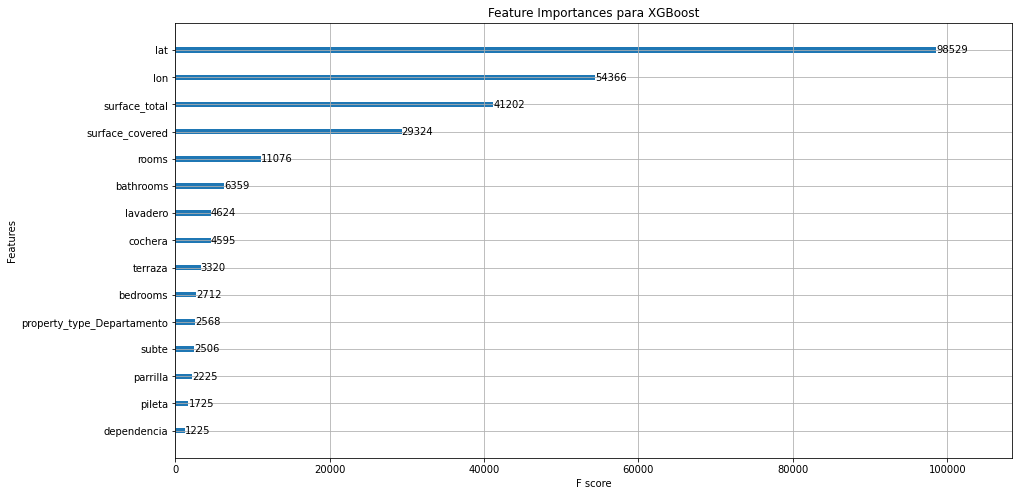

In [ ]:
plt.rcParams['figure.figsize'] = (15,8)
xgb.plot_importance(modelo,max_num_features=15, title='Feature Importances para XGBoost')

## Neural Net

In [ ]:
import tensorflow as tf

In [ ]:
model = tf.keras.Sequential()

In [ ]:
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(1))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
X = data

In [ ]:
scaler_tf = MinMaxScaler(feature_range=(0, 1))
# Scale both the training inputs and outputs
scaled_train = scaler_tf.fit_transform(X)
#scaled_test = scaler.transform(test_df)

# Print out the adjustment that the scaler applied to the total_earnings column of data
print("Note: price were scaled by multiplying by {:.10f} and adding {:.6f}".format(scaler_tf.scale_[7], scaler_tf.min_[7]))

multiplied_by = scaler_tf.scale_[7]
added = scaler_tf.min_[7]

scaled_train_df = pd.DataFrame(scaled_train, columns=X.columns.values)

Note: price were scaled by multiplying by 0.2127439258 and adding -1.959444


In [ ]:
X = scaled_train_df.drop(['price'], axis=1).values
Y = scaled_train_df['price'].values

In [ ]:
# Train the model
model.fit(
    X[10000:],
    Y[10000:],
    epochs=50,
    shuffle=True,
    verbose=2
)

Epoch 1/50
2958/2958 - 4s - loss: 0.0038
Epoch 2/50
2958/2958 - 3s - loss: 0.0029
Epoch 3/50
2958/2958 - 3s - loss: 0.0028
Epoch 4/50
2958/2958 - 4s - loss: 0.0027
Epoch 5/50
2958/2958 - 3s - loss: 0.0027
Epoch 6/50
2958/2958 - 3s - loss: 0.0027
Epoch 7/50
2958/2958 - 3s - loss: 0.0026
Epoch 8/50
2958/2958 - 3s - loss: 0.0026
Epoch 9/50
2958/2958 - 3s - loss: 0.0026
Epoch 10/50
2958/2958 - 3s - loss: 0.0026
Epoch 11/50
2958/2958 - 4s - loss: 0.0025
Epoch 12/50
2958/2958 - 4s - loss: 0.0025
Epoch 13/50
2958/2958 - 3s - loss: 0.0025
Epoch 14/50
2958/2958 - 3s - loss: 0.0025
Epoch 15/50
2958/2958 - 3s - loss: 0.0025
Epoch 16/50
2958/2958 - 3s - loss: 0.0025
Epoch 17/50
2958/2958 - 3s - loss: 0.0024
Epoch 18/50
2958/2958 - 3s - loss: 0.0024
Epoch 19/50
2958/2958 - 3s - loss: 0.0024
Epoch 20/50
2958/2958 - 3s - loss: 0.0024
Epoch 21/50
2958/2958 - 3s - loss: 0.0024
Epoch 22/50
2958/2958 - 3s - loss: 0.0024
Epoch 23/50
2958/2958 - 3s - loss: 0.0024
Epoch 24/50
2958/2958 - 3s - loss: 0.0024
E

In [ ]:
test_error_rate = model.evaluate(X[:10000], Y[:10000], verbose=0)
print("The mean squared error (MSE) for the test data set is: {}".format(test_error_rate))

The mean squared error (MSE) for the test data set is: 0.0024361161049455404


In [ ]:
prediction = model.predict(X[:10000])

In [ ]:
prediction -= added
prediction /= multiplied_by

In [ ]:
print('Neural net - logaritmo en price:')
print('RECM:', np.sqrt(mean_squared_error(np.exp(data.price[:10000]) , np.exp(prediction))).round(3))
print('MAE:', (mean_absolute_error(np.exp(data.price[:10000]) , np.exp(prediction))).round(3))
print('R2:', r2_score(np.exp(data.price[:10000]) , np.exp(prediction)).round(3))

Neural net - logaritmo en price:
RECM: 50592.157
MAE: 31259.725
R2: 0.825
